# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable
from ipywidgets import interact

pd.options.mode.copy_on_write = True

In [3]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [4]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )

MASSIVE_RT_REVIEW_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movie_reviews.csv",
                               "Massive Rotten Tomatoes Reviews",
                               "Dataset containing ~1.4M+ reviews from RT",                               
                               {
                                    "id": "Unique identifier for each movie (matches the ID in the movies dataset).",
                                    "reviewId": "Unique identifier for each critic review.",
                                    "creationDate": "The date the review was published.",
                                    "criticName": "Name of the critic who wrote the review.",
                                    "isTopCritic": "Indicates if the critic is considered a 'Top Critic' (True or False).",
                                    "originalScore": "The score provided by the critic.",
                                    "reviewState": "The status of the review (e.g., 'fresh', 'rotten').",
                                    "publicatioName": "The name of the publication where the review was published.",
                                    "reviewText": "The full text of the critic review.",
                                    "scoreSentiment": "The sentiment of the critic's score (e.g., 'positive', 'negative', 'neutral').",
                                    "reviewUrl": "The url of the review"
                                }
                            )

RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,MASSIVE_RT_REVIEW_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [5]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 7 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Massive Rotten Tomatoes Reviews, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [6]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [7]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

## I- Popularity analysis

##

In [8]:
def preprocessing_rt_rev_ds():
    reviews_df = MASSIVE_RT_REVIEW_DS.df.copy()
    movies_df = MASSIVE_RT_MOVIE_DS.df.copy()
    
    print(f"Reviews Dataset: {reviews_df.shape[0]} rows, {reviews_df.shape[1]} columns")
    print(f"Movies Dataset: {movies_df.shape[0]} rows, {movies_df.shape[1]} columns")
    
    # Merge the datasets on 'id'
    combined_df = pd.merge(reviews_df, movies_df, on="id", how="inner")
    print(f"Combined Dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")
    return combined_df

In [9]:
combined_df = preprocessing_rt_rev_ds()

Reviews Dataset: 1444963 rows, 11 columns
Movies Dataset: 143258 rows, 16 columns
Combined Dataset: 1469543 rows, 26 columns


In [10]:
def display_chart(movie):
    # Used to display an interactive chart -- given a movie, 
    # gets the expert and non-expert rating
    
    movie_data = combined_df[combined_df['title'].str.lower() == movie.lower()]
    
    if movie_data.empty:
        print("Movie not found. Try another title.")
        return
    else:
      
        scores = {}
        if pd.notna(movie_data['audienceScore'].values[0]):
            scores['Audience Score'] = movie_data['audienceScore'].values[0]
        if pd.notna(movie_data['tomatoMeter'].values[0]):
            scores['Tomatometer'] = movie_data['tomatoMeter'].values[0]
        
     
        if not scores:
            print("No scores available for this movie.")
            return
        
    
        is_comedy = movie_data['genre'].str.contains('Comedy', case=False, na=False).values[0]


        bar_colors = [COLOR_PALETTE[4], COLOR_PALETTE[2]] if is_comedy else [COLOR_PALETTE[1], COLOR_PALETTE[3]]

        labels = list(scores.keys())
        values = list(scores.values())
        
        _, ax = plt.subplots(figsize=(8, 5))
        
      
        bars = ax.bar(labels, values, color=bar_colors[:len(values)])
        

        for bar, score in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, 
                    f'{score}%', ha='center', va='bottom', fontsize=12, color='black')
        
        #Title (comedy or not)
        genre_info = "(Comedy)" if is_comedy else "(Non-Comedy)"
        ax.set_title(f'Scores for "{movie}" {genre_info}', fontsize=14)
        ax.set_xlabel('Score Type', fontsize=12)
        ax.set_ylabel('Score (%)', fontsize=12)
        
        plt.tight_layout()
        plt.show()

interact(display_chart, movie="love")

interactive(children=(Text(value='love', description='movie'), Output()), _dom_classes=('widget-interact',))

<function __main__.display_chart(movie)>

In [11]:
def filter_comedy_review():
    return combined_df[combined_df['genre'].str.contains('Comedy', case=False, na=False)]


In [12]:
def most_frequent_comedy_genre():
    comedy_df = filter_comedy_review()
    
    if 'genre' not in comedy_df.columns:
        print("Error: 'genre' column not found in comedy_df")
        return
    
    associated_genres = []
    for genre_list in comedy_df['genre'].str.lower().str.split(',\s*'):
        if isinstance(genre_list, list):
            # Add all genres except "comedy" to the temporary list
            associated_genres.extend([genre for genre in genre_list if genre != "comedy"])

    associated_genre_counts = pd.Series(associated_genres).value_counts()

    print(associated_genre_counts.head(10))

    fig, ax = plt.subplots(figsize=(10, 6))

    associated_genre_counts.head(10).plot(kind='bar', color=COLOR_PALETTE[:10], ax=ax)

    ax.set_title('Most Frequent Genres Associated with "Comedy"', fontsize=14)
    ax.set_xlabel('Associated Genre', fontsize=12)
    ax.set_ylabel('Number of Movies', fontsize=12)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Removille\AppData\Local\Temp\ipykernel_11552\218771490.py:9: SyntaxWarning: invalid escape sequence '\s'
  for genre_list in comedy_df['genre'].str.lower().str.split(',\s*'):


drama                 141631
romance                72762
adventure              58692
kids & family          54773
action                 38820
fantasy                37199
animation              36024
mystery & thriller     20966
horror                 18253
musical                12936
Name: count, dtype: int64


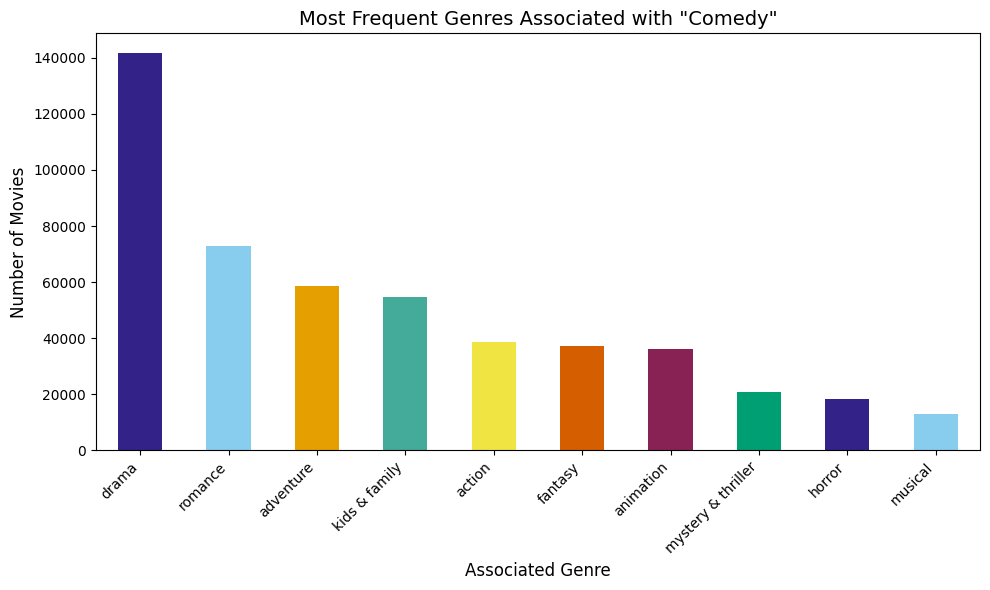

In [13]:
most_frequent_comedy_genre()

## II. Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


In [14]:
useful_col = ['wikipedia_id','title','box_office_revenue','genres']
unfiltered_df_box_office = CMU_MOVIES_DS.df[useful_col].copy()
df_box_office = unfiltered_df_box_office[unfiltered_df_box_office['genres'].str.contains('comedy', case=False, na=False)]
count_na = df_box_office['box_office_revenue'].isna().sum()
print(count_na/len(df_box_office))

0.8392791297935103


In the initial dataset the number of missing box-office values is very high, about 84% of the movies are missing a box-office value.

Standardizing the movie names is necessary to improve the accuracy of the merges between the different dataframes. 

In [15]:
def standardize_title(title):
    if not isinstance(title, str):
        return None
    title = title.lower()
    title = re.sub(r'[^a-z0-9\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df_raw_rt_rev = MASSIVE_RT_REVIEW_DS.df.copy()
df_raw_rt = MASSIVE_RT_MOVIE_DS.df.copy()

df_short_rt = df_raw_rt_rev[["id","isTopCritic","originalScore","scoreSentiment"]]
df_id_title = df_raw_rt[["id","title"]]

In [16]:
merged_raws = pd.merge(df_id_title, df_short_rt, on= "id", how="inner")

merged_raws["title"] = merged_raws["title"].apply(standardize_title)
df_box_office["title"] = df_box_office["title"].apply(standardize_title)

merge_big_dfs = pd.merge(df_box_office, merged_raws, on='title', how='inner')
merge_big_dfs = merge_big_dfs.drop_duplicates()
merge_big_dfs = merge_big_dfs[merge_big_dfs["originalScore"].notna()].copy()
df_expert_critics = merge_big_dfs[merge_big_dfs["isTopCritic"]==True]
list_movies = df_expert_critics["title"].unique() 
print(f"Number of comedies : {len(list_movies)}")

Number of comedies : 5340


The merge of the initial dataset with the 'big' Rotten tomatoes one gives an exploitable dataset : 5340 comedies with critic score and reviews. There are still some missing values (=NaN) on the box office column from the initial dataset, these missing values will be completed with another dataset.

In [17]:
df_plot = CMU_PLOTS_DS.df
df_1st_plot = CMU_PLOTS_DS.df.head(5)

In [18]:
from llmware.agents import LLMfx

def get_one_sentiment_classification(text):
    agent = LLMfx(verbose=True)
    agent.load_tool("sentiment")
    sentiment = agent.sentiment(text)
    
    sentiment_value = sentiment["llm_response"]["sentiment"]
    confidence_level = sentiment["confidence_score"]
    
    print("Plot:", text)
    print("Sentiment:", sentiment_value)
    print("Confidence level", confidence_level)
    
    return sentiment_value, confidence_level

# Application of the analysis on the plots
df_1st_plot[['Sentiment', 'Confidence']] = df_1st_plot['plot'].swifter.apply(
    lambda x: pd.Series(get_one_sentiment_classification(x))
)


ModuleNotFoundError: No module named 'llmware'

The computation of the sentiment analysis for the first 5 plots of the dataset takes 2min34s. We linearize this values using the number of words in the 5 plots and the number of words in all the comedy plots : 

In [ ]:
df_merge_IDs = pd.merge(df_box_office, df_plot, on='wikipedia_id', how='inner')

time = 154
words = ' '.join(df_1st_plot["plot"]).split()
words_comedy = ' '.join(df_merge_IDs["plot"]).split()
computation_time = ((len(words_comedy)/len(words))*time)/(24*3600)
print(f"Linear estimation of the computation time for all the comedy plot summaries: {computation_time} days")


We have a computation time of about 3 days which is quite long, this computation time can probably be optimized later. This part of the code only has to be ran once, the results would be saved.

## III. Per-genre analysis 

As this section neither requires any additional datasets, nor does it use any different type of techniques, we do no provide a sample Proof of Concept for it. The final analysis will be ready for P3! 

## IV. Cultural differences

In [19]:
print(f"Preprocessing CMU dataset...")
cmu_cleaned_movies = prepro_cmu_movies(CMU_MOVIES_DS.df)
print(f"Preprocessed CMU dataset!")

Preprocessing CMU dataset...


Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Preprocessed CMU dataset!


In [20]:
total_movies_per_year = cmu_cleaned_movies.groupby('release_date').size().reset_index(name='movie_count')
def get_comedies_mask(df):
    # Returns the (boolean) comedy mask for the given df
    # The `df` has to be of similar format as `prepro_cmu_movies(CMU_MOVIES_DS.df)`
    return df["genres"].apply(lambda genre_list: "Comedy" in genre_list or "comedy" in genre_list)

cmu_comedies = cmu_cleaned_movies[get_comedies_mask(cmu_cleaned_movies)]
comedy_count_by_year = cmu_comedies.groupby('release_date').size().reset_index(name='comedy_count')

movies_per_year = pd.merge(total_movies_per_year, comedy_count_by_year, on='release_date', how='left')
movies_per_year['comedy_count'] = movies_per_year['comedy_count'].fillna(0)
    
movies_per_year['comedy_proportion'] = movies_per_year['comedy_count'] / movies_per_year['movie_count']

movies_per_year = movies_per_year[movies_per_year['release_date'] >= 1900]


In [21]:
print(len(cmu_cleaned_movies))
cmu_cleaned_movies.head()

81741


,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama]


In [22]:
oscar_awards = OSCAR_AWARDS_DS.df
print(len(oscar_awards))
oscar_awards.rename(columns={'film':'title', 'year_film':'release_date'}, inplace = True)
oscar_awards.head()

10889


,release_date,year_ceremony,ceremony,category,name,title,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False


In [23]:
movies_awards = (cmu_cleaned_movies.copy()).merge(oscar_awards, on=['title']).drop(columns=['release_date_x'])
movies_awards = movies_awards.rename(columns={'release_date_y':'release_date'})
print(len(movies_awards))
movies_awards.head()

12434


,wikipedia_id,freebase_id,title,box_office_revenue,runtime,languages,countries,genres,release_date,year_ceremony,ceremony,category,name,winner
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,ART DIRECTION,"Bernard Herzbrun, Boris Leven",False
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,FILM EDITING,Barbara McLean,False
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,MUSIC (Scoring),Alfred Newman,True
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,MUSIC (Song),Music and Lyrics by Irving Berlin,False
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",1938,1939,11,OUTSTANDING PRODUCTION,20th Century-Fox,False


In [24]:
import matplotlib.pyplot as plt

def plot_comedy_proportion(movies_per_year, color):
    """
    Plots the proportion of comedy movies released each year.
    
    Args:
        movies_per_year (DataFrame): DataFrame containing 'release_date' and 'comedy_proportion' columns.
        color (str): Color for the plot line.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        movies_per_year['release_date'], 
        movies_per_year['comedy_proportion'], 
        marker='o', 
        color=color, 
        linestyle='-'
    )
    plt.title('Proportion of Comedy Movies Released Each Year')
    plt.xlabel('Year')
    plt.ylabel('Proportion of Comedy Movies')
    plt.xlim(movies_per_year['release_date'].min(), movies_per_year['release_date'].max())
    plt.grid(True)

def plot_comedy_count(comedy_count_by_year, color):
    """
    Plots the number of comedy movies released each year.
    
    Args:
        comedy_count_by_year (DataFrame): DataFrame containing 'release_date' and 'comedy_count' columns.
        color (str): Color for the plot line.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        comedy_count_by_year['release_date'], 
        comedy_count_by_year['comedy_count'], 
        marker='o', 
        color=color, 
        linestyle='-'
    )
    plt.title('Number of Comedy Movies Released Each Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Comedy Movies')
    plt.grid(True)


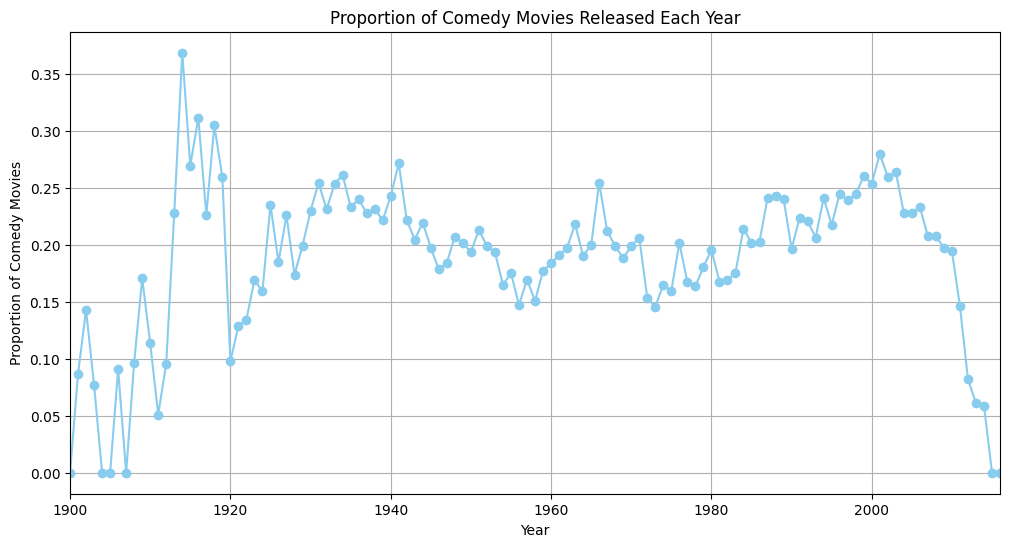

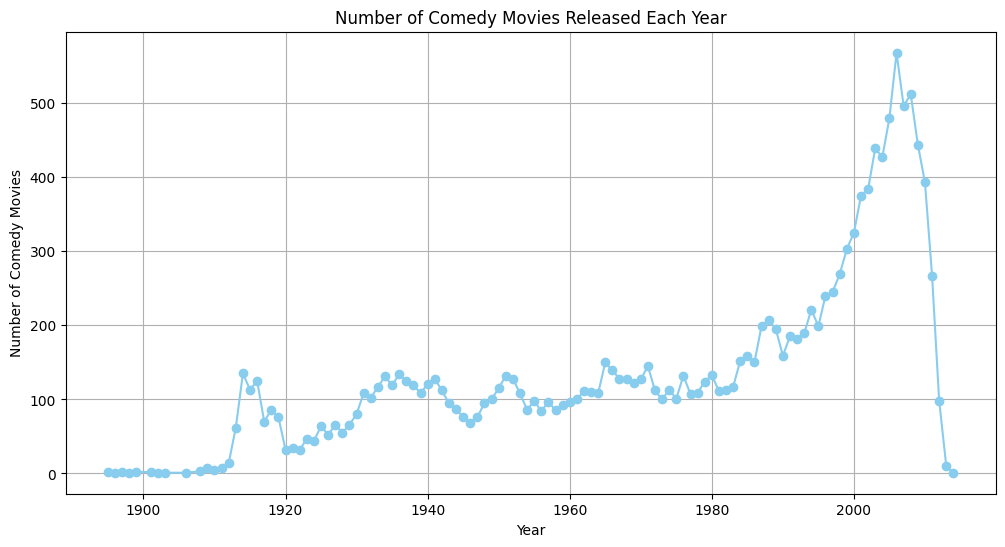

In [25]:
plot_comedy_proportion(movies_per_year, COLOR_PALETTE[1])
plot_comedy_count(comedy_count_by_year, COLOR_PALETTE[1])

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

def explode_countries_and_mark_comedies(movies_df, comedy_mask_function):
    """
    Explodes the 'countries' column and marks comedy movies.
    
    Args:
        movies_df (DataFrame): The DataFrame containing movie data with a 'countries' column.
        comedy_mask_function (function): A function to determine if a movie is a comedy.
    
    Returns:
        DataFrame: A DataFrame with exploded countries and a new 'is_comedy' column.
    """
    movies_exploded = movies_df.explode(column="countries")
    movies_exploded["is_comedy"] = comedy_mask_function(movies_exploded)
    return movies_exploded

def calculate_country_movie_counts(movies_exploded):
    """
    Groups the exploded DataFrame by countries and calculates movie counts.
    
    Args:
        movies_exploded (DataFrame): The DataFrame with exploded 'countries' and 'is_comedy' columns.
    
    Returns:
        DataFrame: A DataFrame with total and comedy movie counts per country.
    """
    country_counts = movies_exploded.groupby('countries').agg(
        total_movies=('countries', 'size'),
        comedy_movies=('is_comedy', 'sum')
    ).reset_index()
    country_counts['comedy_proportion'] = country_counts['comedy_movies'] / country_counts['total_movies']
    return country_counts

def merge_with_geodata(geo_file_path, country_movie_counts):
    """
    Merges movie count data with geospatial data.
    
    Args:
        geo_file_path (str): Path to the shapefile containing country boundaries.
        country_movie_counts (DataFrame): DataFrame with movie counts by country.
    
    Returns:
        GeoDataFrame: A GeoDataFrame with movie proportions merged with geospatial data.
    """
    world = gpd.read_file(geo_file_path)
    return world.set_index('NAME').join(country_movie_counts.set_index('countries'))

def plot_comedy_proportion(world_comedy_gdf):
    """
    Plots the proportion of comedy movies produced by country.
    
    Args:
        world_comedy_gdf (GeoDataFrame): GeoDataFrame with comedy proportions.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_comedy_gdf.plot(
        column='comedy_proportion', 
        ax=ax, 
        legend=True,
        legend_kwds={'label': "Proportion of Comedy Movies", 'orientation': "horizontal"}
    )
    plt.title('Global Proportion of Comedy Movies Produced by Country')
    plt.show()

           countries  total_movies  comedy_movies  comedy_proportion
0        Afghanistan            15              0           0.000000
1            Albania            28              2           0.071429
2            Algeria            43              1           0.023256
3          Argentina          1468            268           0.182561
4            Armenia            16              3           0.187500
..               ...           ...            ...                ...
142  Weimar Republic            68              7           0.102941
143     West Germany           647             93           0.143740
144       Yugoslavia           306             41           0.133987
145           Zambia             3              0           0.000000
146         Zimbabwe             8              2           0.250000

[147 rows x 4 columns]


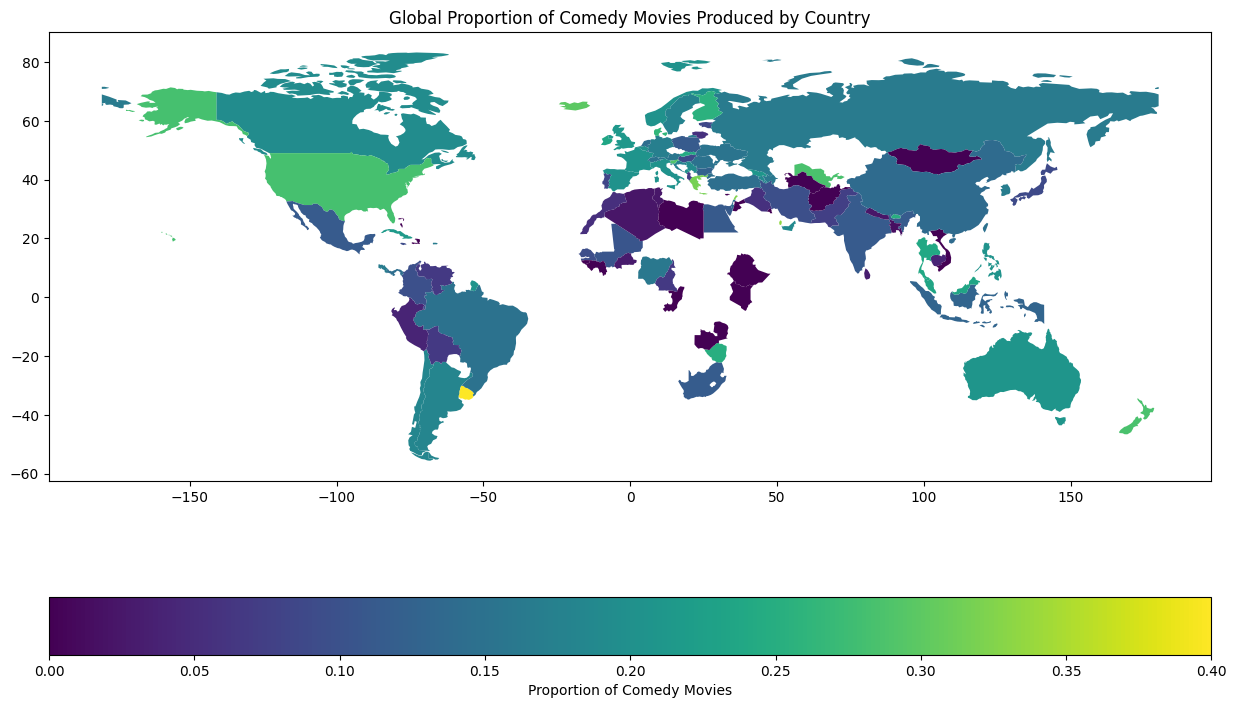

In [27]:
global cmu_cleaned_movies, RES_PATH, get_comedies_mask
movies_exploded_countries = explode_countries_and_mark_comedies(cmu_cleaned_movies, get_comedies_mask)
country_movie_counts = calculate_country_movie_counts(movies_exploded_countries)
print(country_movie_counts)
geo_file_path = RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world_comedy = merge_with_geodata(geo_file_path, country_movie_counts)
plot_comedy_proportion(world_comedy)

plt.show()

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

def explode_countries(movies_df):
    """
    Explodes the 'countries' column to have one country per row.
    
    Args:
        movies_df (DataFrame): DataFrame containing movies with a 'countries' column.
    
    Returns:
        DataFrame: Exploded DataFrame with one row per country.
    """
    return movies_df.explode(column="countries")

def calculate_comedies_by_country(movies_df):
    """
    Groups the DataFrame by countries and calculates comedy counts.
    
    Args:
        movies_df (DataFrame): Exploded DataFrame with a 'countries' column and 'title'.
    
    Returns:
        DataFrame: DataFrame with the count of comedies per country.
    """
    return movies_df.groupby('countries').agg(
        comedy_count=('title', 'count')
    ).reset_index()

def merge_with_geospatial_data(geo_file_path, comedies_count_by_country):
    """
    Merges the comedy count data with geospatial data.
    
    Args:
        geo_file_path (str): Path to the shapefile containing geospatial data.
        comedies_count_by_country (DataFrame): DataFrame with comedy counts per country.
    
    Returns:
        GeoDataFrame: A GeoDataFrame with comedy counts joined with geospatial data.
    """
    world = gpd.read_file(geo_file_path)
    return world.set_index('NAME').join(comedies_count_by_country.set_index('countries'))

def get_top_n_countries(comedies_count_by_country, n=5):
    """
    Finds the top N countries with the most comedy movies.
    
    Args:
        comedies_count_by_country (DataFrame): DataFrame with comedy counts per country.
        n (int): Number of top countries to return.
    
    Returns:
        DataFrame: DataFrame with the top N countries and their comedy counts.
    """
    return comedies_count_by_country.nlargest(n, 'comedy_count')

def plot_comedy_heatmap(world_comedy_gdf, top_countries, color_palette, title):
    """
    Plots a heatmap of comedy counts by country, and annotates the top countries.
    
    Args:
        world_comedy_gdf (GeoDataFrame): GeoDataFrame with comedy counts merged with geospatial data.
        top_countries (DataFrame): DataFrame with the top N countries and their comedy counts.
        color_palette (list): List of colors for styling.
        title (str): Title for the plot.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_comedy_gdf.plot(
        column='comedy_count',
        cmap='YlGnBu',
        ax=ax,
        legend=True,
        legend_kwds={
            'label': "Number of Comedies",
            'orientation': "horizontal"
        }
    )

    # Annotate the top countries
    for i, row in top_countries.iterrows():
        country_row = world_comedy_gdf.loc[row['countries']]
        if not pd.isna(country_row['geometry']):
            offset = i * 0.2
            plt.text(
                country_row.geometry.centroid.x,
                country_row.geometry.centroid.y + offset,
                f"{row['countries']}: {int(row['comedy_count'])}",
                fontsize=10,
                color=color_palette[0],
                fontweight='bold',
                va='bottom',
                ha='left'
            )
    
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

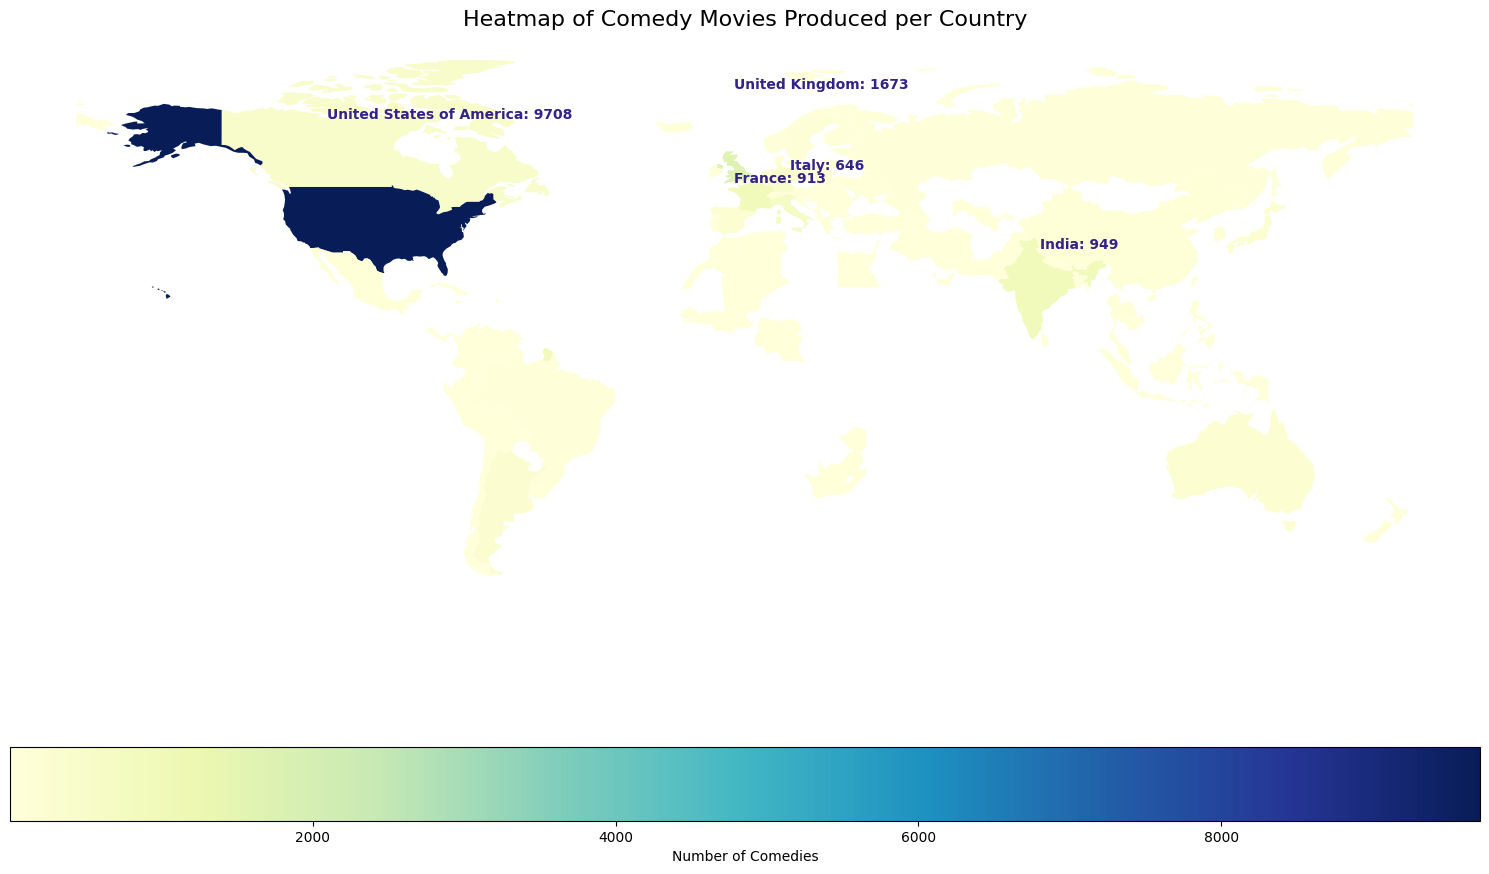

In [29]:
global cmu_comedies, RES_PATH, COLOR_PALETTE

# Explode countries
comedies_per_country = explode_countries(cmu_comedies)

# Calculate comedy counts by country
comedies_count_by_country = calculate_comedies_by_country(comedies_per_country)
    
# Merge with geospatial data
geo_file_path = RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world_comedy = merge_with_geospatial_data(geo_file_path, comedies_count_by_country)
    
# Get top 5 countries
top_5_countries = get_top_n_countries(comedies_count_by_country, n=5)
    
# Plot heatmap
plot_comedy_heatmap(
    world_comedy,
    top_5_countries,
    COLOR_PALETTE,
    'Heatmap of Comedy Movies Produced per Country'
)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_revenues_per_year(movies_df, comedies_df):
    """
    Calculates the total and comedy revenues per year, and the proportion of comedy revenues.
    
    Args:
        movies_df (DataFrame): DataFrame with all movies, containing 'release_date' and 'box_office_revenue'.
        comedies_df (DataFrame): DataFrame with comedy movies, containing 'release_date' and 'box_office_revenue'.
    
    Returns:
        DataFrame: DataFrame with year, total revenue, comedy revenue, and comedy revenue proportion.
    """
    # Total revenues per year
    total_revenues_per_year = movies_df.groupby('release_date')['box_office_revenue'].sum().reset_index(name='total_revenue')
    
    # Comedy revenues per year
    comedy_revenues_by_year = comedies_df.groupby('release_date')['box_office_revenue'].sum().reset_index(name='comedy_revenue')
    
    # Merge and calculate proportions
    revenues_per_year = pd.merge(total_revenues_per_year, comedy_revenues_by_year, on='release_date', how='left')
    revenues_per_year['comedy_revenue'] = revenues_per_year['comedy_revenue'].fillna(0)
    revenues_per_year['comedy_revenue'] = revenues_per_year['comedy_revenue'] / revenues_per_year['total_revenue']
    
    # Filter out years before 1900
    return revenues_per_year[revenues_per_year['release_date'] >= 1900]

def plot_comedy_revenue_trend(revenues_per_year, color, title):
    """
    Plots the proportion of comedy revenues over time.
    
    Args:
        revenues_per_year (DataFrame): DataFrame with 'release_date' and 'comedy_revenue' columns.
        color (str): Color for the plot line.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        revenues_per_year['release_date'], 
        revenues_per_year['comedy_revenue'], 
        marker='o', 
        color=color, 
        linestyle='-'
    )
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Proportion of Comedy Movies Revenues')
    plt.xlim(revenues_per_year['release_date'].min(), revenues_per_year['release_date'].max())
    plt.grid(True)
    plt.show()


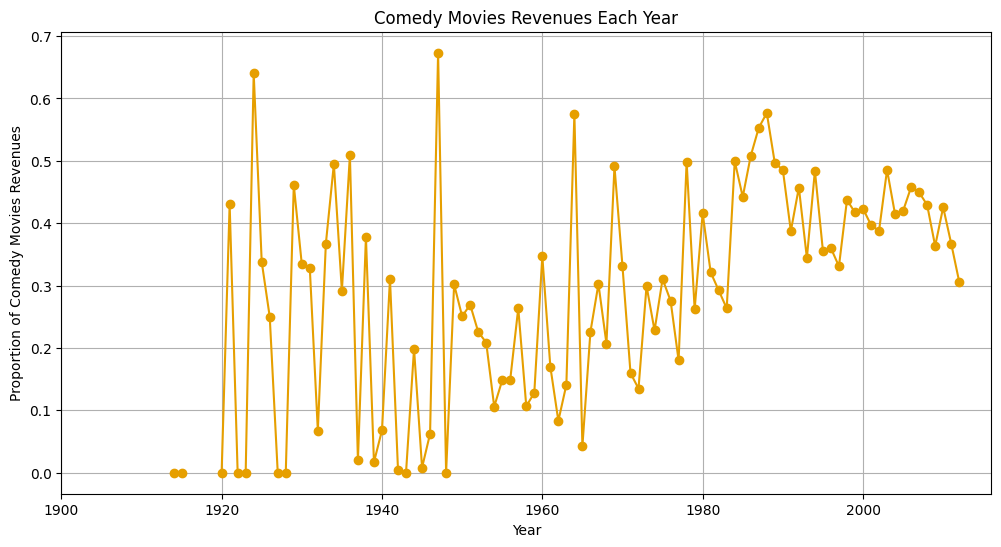

In [31]:
global cmu_cleaned_movies, cmu_comedies, COLOR_PALETTE
    
# Step 1: Calculate revenues per year
revenues_per_year = calculate_revenues_per_year(cmu_cleaned_movies, cmu_comedies)
    
# Step 2: Plot the trend
plot_comedy_revenue_trend(
    revenues_per_year, 
    COLOR_PALETTE[2], 
    'Comedy Movies Revenues Each Year'
)

In [32]:
import matplotlib.pyplot as plt

def plot_dual_trends(x1, y1, label1, color1, x2, y2, label2, color2, title, xlabel, ylabel):
    """
    Plots two trends on the same graph.
    
    Args:
        x1, y1 (Series): Data for the first trend (x and y values).
        label1 (str): Label for the first trend.
        color1 (str): Color for the first trend.
        x2, y2 (Series): Data for the second trend (x and y values).
        label2 (str): Label for the second trend.
        color2 (str): Color for the second trend.
        title (str): Title for the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    plt.figure(figsize=(12, 6))

    # Plot the first trend
    plt.plot(x1, y1, marker='o', color=color1, linestyle='-', label=label1)
    
    # Plot the second trend
    plt.plot(x2, y2, marker='o', color=color2, linestyle='-', label=label2)

    # Add titles, labels, and legend
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Set x-axis limits
    plt.xlim(min(x1.min(), x2.min()), max(x1.max(), x2.max()))

    # Show the plot
    plt.show()

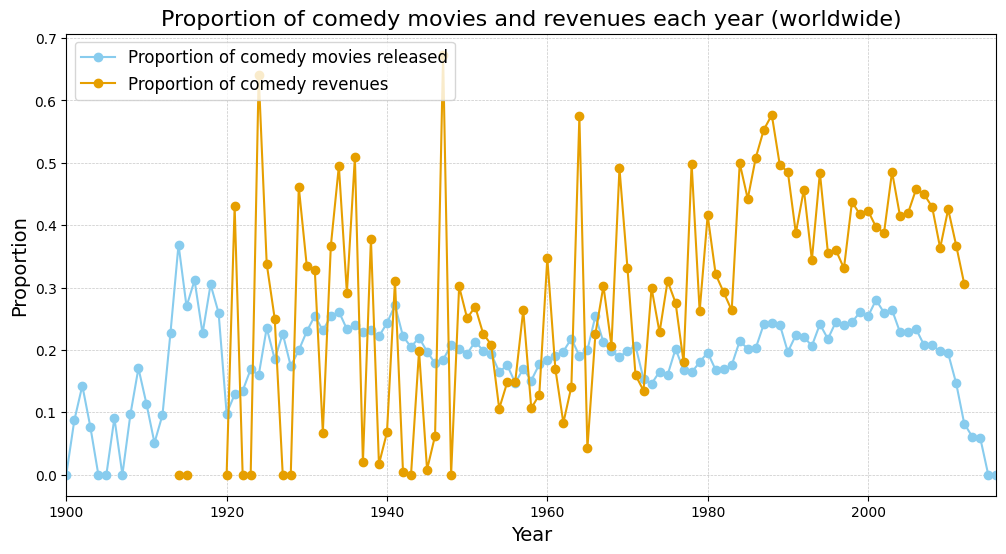

In [33]:
global movies_per_year, revenues_per_year, COLOR_PALETTE

# Call the dual trend plotting function
plot_dual_trends(
    x1=movies_per_year['release_date'], 
    y1=movies_per_year['comedy_proportion'], 
    label1='Proportion of comedy movies released', 
    color1=COLOR_PALETTE[1], 
    x2=revenues_per_year['release_date'], 
    y2=revenues_per_year['comedy_revenue'], 
    label2='Proportion of comedy revenues', 
    color2=COLOR_PALETTE[2], 
    title='Proportion of comedy movies and revenues each year (worldwide)',
    xlabel='Year', 
    ylabel='Proportion'
)

In [34]:
cmu_comedy_movies = cmu_cleaned_movies[cmu_cleaned_movies['genres'].apply(lambda genres: 'Comedy' in genres)]
print(len(cmu_comedy_movies))

16349


In [35]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def prepare_awards_comedy_data(movies_awards_df):
    """
    Prepares the data for analyzing award-winning comedy movies by country.
    
    Args:
        movies_awards_df (DataFrame): DataFrame containing movie awards data with 'genres' and 'countries'.
    
    Returns:
        DataFrame: A DataFrame grouped by countries with winning and non-winning counts.
    """
    # Filter for comedy movies
    awards_comedy_movies = movies_awards_df[movies_awards_df['genres'].apply(lambda genres: 'Comedy' in genres)]
    awards_comedy_movies = awards_comedy_movies.explode('countries')
    
    # Group by countries and winner status
    country_analysis = awards_comedy_movies.groupby(['countries', 'winner']).size().reset_index(name='count')
    
    # Pivot to get winning and non-winning counts
    country_pivot = country_analysis.pivot(index='countries', columns='winner', values='count').fillna(0)
    country_pivot.columns = ['Non_Winning_Comedies', 'Winning_Comedies']
    
    # Add total comedies and calculate winning percentage
    country_pivot['Total_Comedies'] = country_pivot['Non_Winning_Comedies'] + country_pivot['Winning_Comedies']
    country_pivot['Winning_Percentage'] = (country_pivot['Winning_Comedies'] / country_pivot['Total_Comedies']) * 100
    country_pivot['Winning_Percentage'] = country_pivot['Winning_Percentage'].replace([float('inf'), float('nan')], 0)
    
    # Sort by winning percentage
    return country_pivot.sort_values(by='Winning_Percentage', ascending=False).reset_index()

def merge_with_geospatial_data(geo_file_path, country_pivot_df):
    """
    Merges the comedy awards data with geospatial data.
    
    Args:
        geo_file_path (str): Path to the shapefile containing geospatial data.
        country_pivot_df (DataFrame): DataFrame with comedy award analysis by country.
    
    Returns:
        GeoDataFrame: GeoDataFrame containing geospatial and comedy award data.
    """
    world = gpd.read_file(geo_file_path)
    return world.set_index('NAME').join(country_pivot_df.set_index('countries'))

def plot_global_award_map(world_comedy_gdf, column, title, legend_label):
    """
    Plots a global map showing award data for comedy movies.
    
    Args:
        world_comedy_gdf (GeoDataFrame): GeoDataFrame with geospatial and award data.
        column (str): Column to visualize on the map.
        title (str): Title for the plot.
        legend_label (str): Label for the legend.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world_comedy_gdf.plot(
        column=column,
        ax=ax,
        legend=True,
        legend_kwds={
            'label': legend_label,
            'orientation': "horizontal"
        }
    )
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

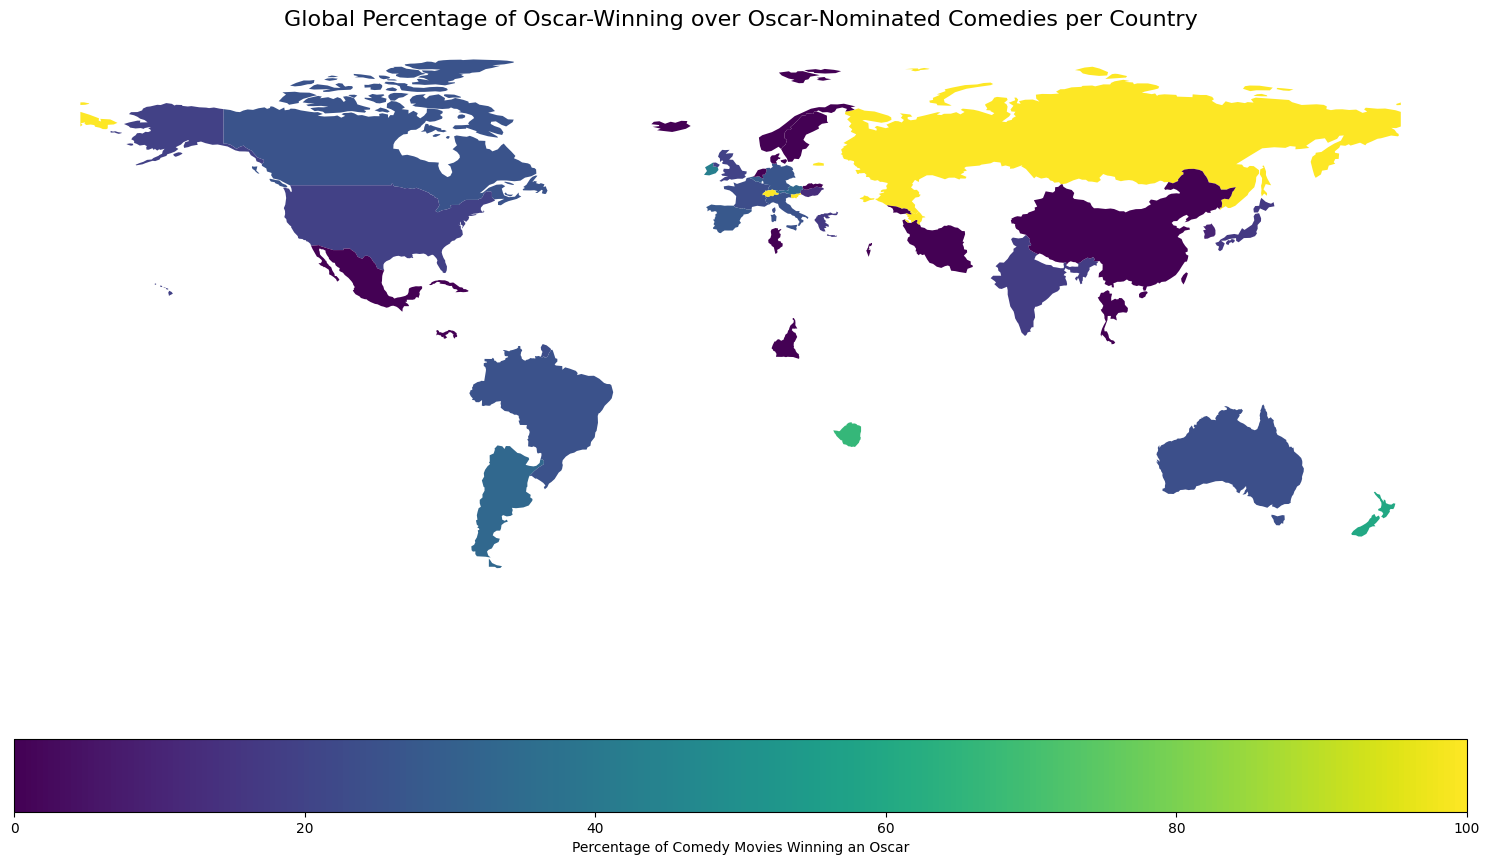

In [36]:
global movies_awards, RES_PATH
    
# Step 1: Prepare the comedy award data
country_pivot_sorted = prepare_awards_comedy_data(movies_awards)
    
# Step 2: Merge with geospatial data
geo_file_path = RES_PATH + 'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
world_comedy = merge_with_geospatial_data(geo_file_path, country_pivot_sorted)
    
# Step 3: Plot the global map
plot_global_award_map(
    world_comedy,
    column='Winning_Percentage',
    title='Global Percentage of Oscar-Winning over Oscar-Nominated Comedies per Country',
    legend_label="Percentage of Comedy Movies Winning an Oscar"
)


In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def prepare_award_comparison_data(movies_awards_df):
    """
    Prepares the data for comparing total award-winning movies and award-winning comedies by country.
    
    Args:
        movies_awards_df (DataFrame): DataFrame containing award data with 'winner', 'genres', and 'countries'.
    
    Returns:
        DataFrame: A DataFrame with 'countries', total winning movies, and winning comedies.
    """
    # Filter for winning movies
    winning_movies = movies_awards_df[movies_awards_df['winner'] == True]
    winning_movies = winning_movies.explode('countries')
    
    # Total award-winning movies per country
    total_award_winning = winning_movies.groupby('countries').size().reset_index(name='Winning_Movies_Total')
    
    # Filter for winning comedy movies
    winning_comedies = winning_movies[winning_movies['genres'].apply(lambda genres: 'Comedy' in genres)]
    comedy_award_winning = winning_comedies.groupby('countries').size().reset_index(name='Winning_Comedies')
    
    # Merge the two dataframes
    country_comparison = total_award_winning.merge(comedy_award_winning, on='countries', how='outer').fillna(0)
    
    # Convert to integers and calculate the comedy percentage
    country_comparison['Winning_Movies_Total'] = country_comparison['Winning_Movies_Total'].astype(int)
    country_comparison['Winning_Comedies'] = country_comparison['Winning_Comedies'].astype(int)
    
    # Calculate the percentage of winning comedies
    country_comparison['Comedy_Percentage'] = (country_comparison['Winning_Comedies'] / country_comparison['Winning_Movies_Total']) * 100
    country_comparison['Comedy_Percentage'] = country_comparison['Comedy_Percentage'].fillna(0)

    country_comparison = country_comparison.sort_values(by='Comedy_Percentage', ascending=False)
    country_comparison = country_comparison.sort_values(by='Winning_Movies_Total', ascending=False)
    
    return country_comparison

def plot_comedy_vs_total_awards(country_comparison_df, color_palette):
    """
    Plots a bar chart comparing total award-winning movies vs. winning comedies by country.
    
    Args:
        country_comparison_df (DataFrame): DataFrame with country comparison data (total awards and winning comedies).
        color_palette (list): List of colors for the bars.
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plotting the total winning movies and winning comedies
    ax.bar(country_comparison_df['countries'], country_comparison_df['Winning_Movies_Total'], 
           label='Total Winning Movies', alpha=0.7, color=color_palette[2])
    ax.bar(country_comparison_df['countries'], country_comparison_df['Winning_Comedies'], 
           label='Winning Comedies', alpha=0.7, color=color_palette[1])

    # Set y-axis to log scale
    ax.set_yscale('log')

    # Set labels and title
    plt.xlabel('Countries')
    plt.ylabel('Number of Movies (Log Scale)')
    plt.title('Comparison of Award-Winning Comedies vs. Total Award-Winning Movies Per Country')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

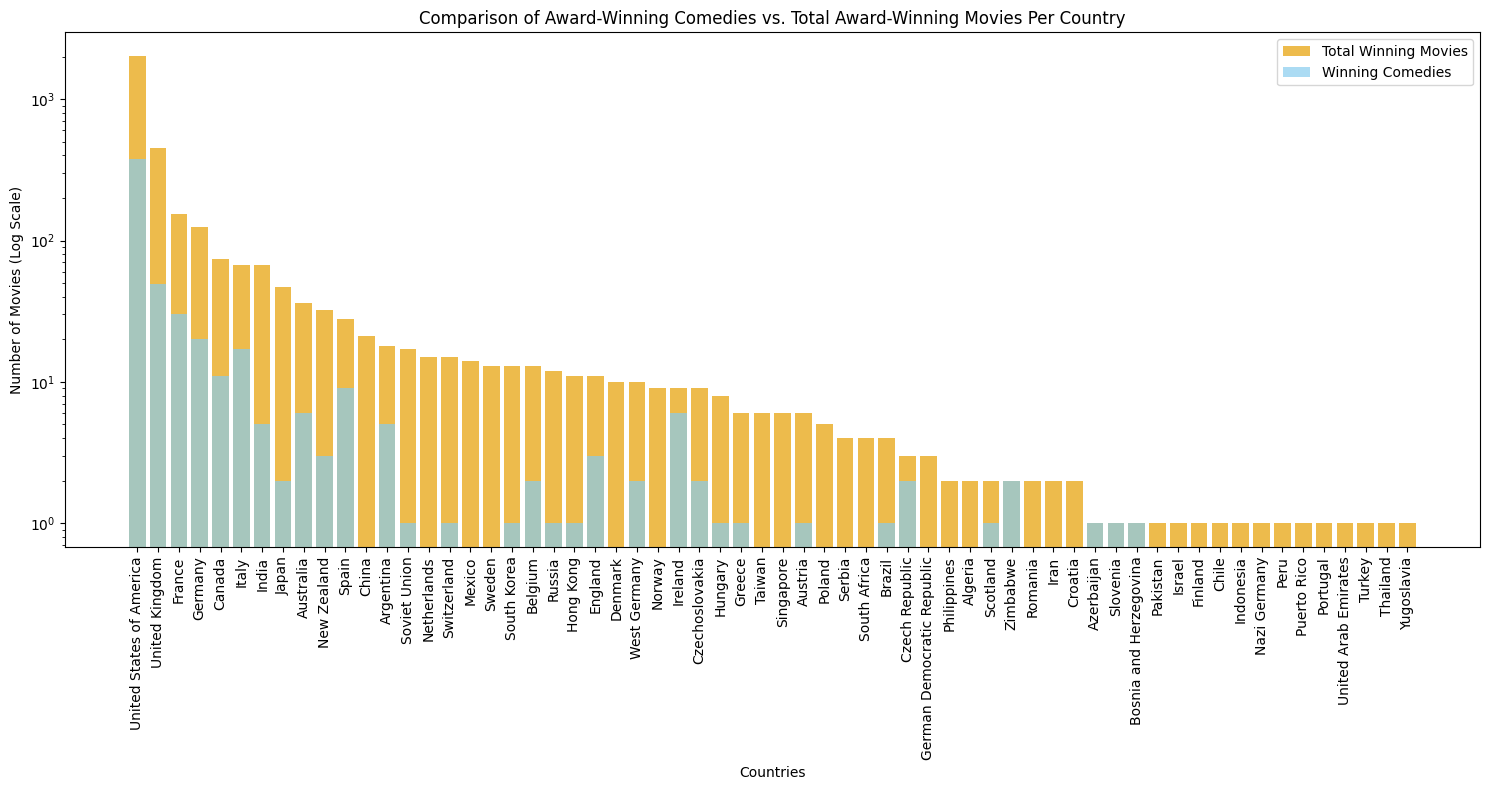

In [38]:
global movies_awards, COLOR_PALETTE

# Step 1: Prepare the award comparison data
country_comparison_df = prepare_award_comparison_data(movies_awards)
    
# Step 2: Plot the comparison
plot_comedy_vs_total_awards(country_comparison_df, COLOR_PALETTE)

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_comedy_percentage(country_comparison_df):
    """
    Adds a new column to the DataFrame calculating the percentage of award-winning comedies.
    
    Args:
        country_comparison_df (DataFrame): DataFrame containing winning comedies and total winning movies by country.
    
    Returns:
        DataFrame: The original DataFrame with an additional column for the comedy winning percentage.
    """
    country_comparison_df['Winning_Comedies_Percentage'] = (
        country_comparison_df['Winning_Comedies'] / country_comparison_df['Winning_Movies_Total'] * 100
    )
    return country_comparison_df

def plot_comedy_percentage(country_comparison_df, color_palette):
    """
    Plots a bar chart showing the percentage of award-winning comedies per country.
    
    Args:
        country_comparison_df (DataFrame): DataFrame with the 'Winning_Comedies_Percentage' column.
        color_palette (list): List of colors for plotting.
    """
    fig, ax = plt.subplots(figsize=(15, 8))

    # Plot the percentage of winning comedies
    ax.bar(country_comparison_df['countries'], country_comparison_df['Winning_Comedies_Percentage'], 
           label='Winning Comedies (%)', alpha=0.7, color=color_palette[1])

    # Set labels and title
    ax.set_ylabel('Percentage of Winning Awards Comedies (%)')
    plt.xlabel('Countries')
    plt.title('Proportion of Award-Winning Comedies Over Award-Winning Total Movies per Country')

    # Rotate x-axis labels and add legend
    plt.xticks(rotation=90)
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

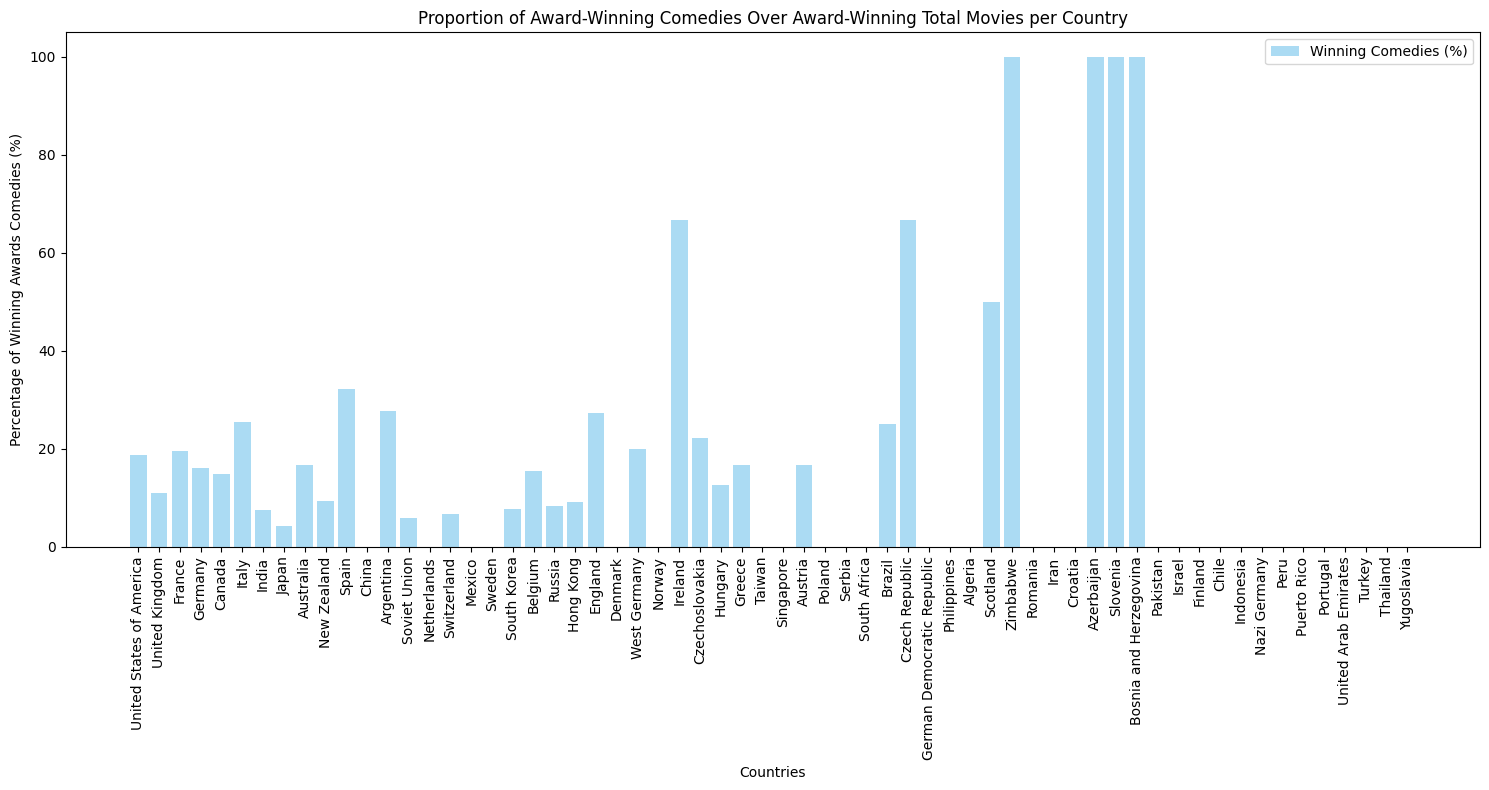

In [ ]:
    
# Step 1: Calculate the percentage of winning comedies
country_comparison_with_percentage = calculate_comedy_percentage(country_comparison_df)
    
# Step 2: Plot the comparison
plot_comedy_percentage(country_comparison_with_percentage, COLOR_PALETTE)

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_comedy_data(awards_comedy_movies_df):
    """
    Prepares the winning and non-winning comedy data by calculating the number of languages.
    
    Args:
        awards_comedy_movies_df (DataFrame): DataFrame containing comedy movie data with 'winner', 'languages', etc.
    
    Returns:
        DataFrame: A DataFrame containing the combined features of winning and non-winning comedies.
    """
    winning_comedies = awards_comedy_movies_df[awards_comedy_movies_df['winner'] == True]
    non_winning_comedies = awards_comedy_movies_df[awards_comedy_movies_df['winner'] == False]
    
    # Calculate the number of languages
    winning_comedies['num_languages'] = winning_comedies['languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    non_winning_comedies['num_languages'] = non_winning_comedies['languages'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Combine winning and non-winning comedies into a single DataFrame
    comedy_features = pd.DataFrame({
        'Runtime': winning_comedies['runtime'].tolist() + non_winning_comedies['runtime'].tolist(),
        'Box Office Revenue': winning_comedies['box_office_revenue'].tolist() + non_winning_comedies['box_office_revenue'].tolist(),
        'Number of Languages': winning_comedies['num_languages'].tolist() + non_winning_comedies['num_languages'].tolist(),
        'Winner': ['Winning'] * len(winning_comedies) + ['Non-Winning'] * len(non_winning_comedies)
    })
    
    return comedy_features

def plot_comedy_feature_comparison(comedy_features_df, features_to_compare, color_palette):
    """
    Plots violin and strip plots comparing features between winning and non-winning comedies.
    
    Args:
        comedy_features_df (DataFrame): DataFrame containing the features to compare between winning and non-winning comedies.
        features_to_compare (list): List of feature names to be compared (e.g., 'Runtime', 'Box Office Revenue').
        color_palette (list): List of colors for the plots.
    """
    plt.figure(figsize=(12, len(features_to_compare) * 5))

    for i, feature in enumerate(features_to_compare, 1):
        plt.subplot(len(features_to_compare), 1, i)
        
        # Violin plot
        sns.violinplot(data=comedy_features_df, x='Winner', y=feature, palette=color_palette[6:8], inner='quartile')
        
        # Strip plot
        sns.stripplot(data=comedy_features_df, x='Winner', y=feature, color='k', alpha=0.5, size=3, jitter=True)
        
        # Add title and labels
        plt.title(f'Comparison of {feature}: Winning vs. Non-Winning Comedies', fontsize=16)
        plt.xlabel('Award Outcome', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Tight layout to avoid overlap
    plt.tight_layout()
    plt.show()

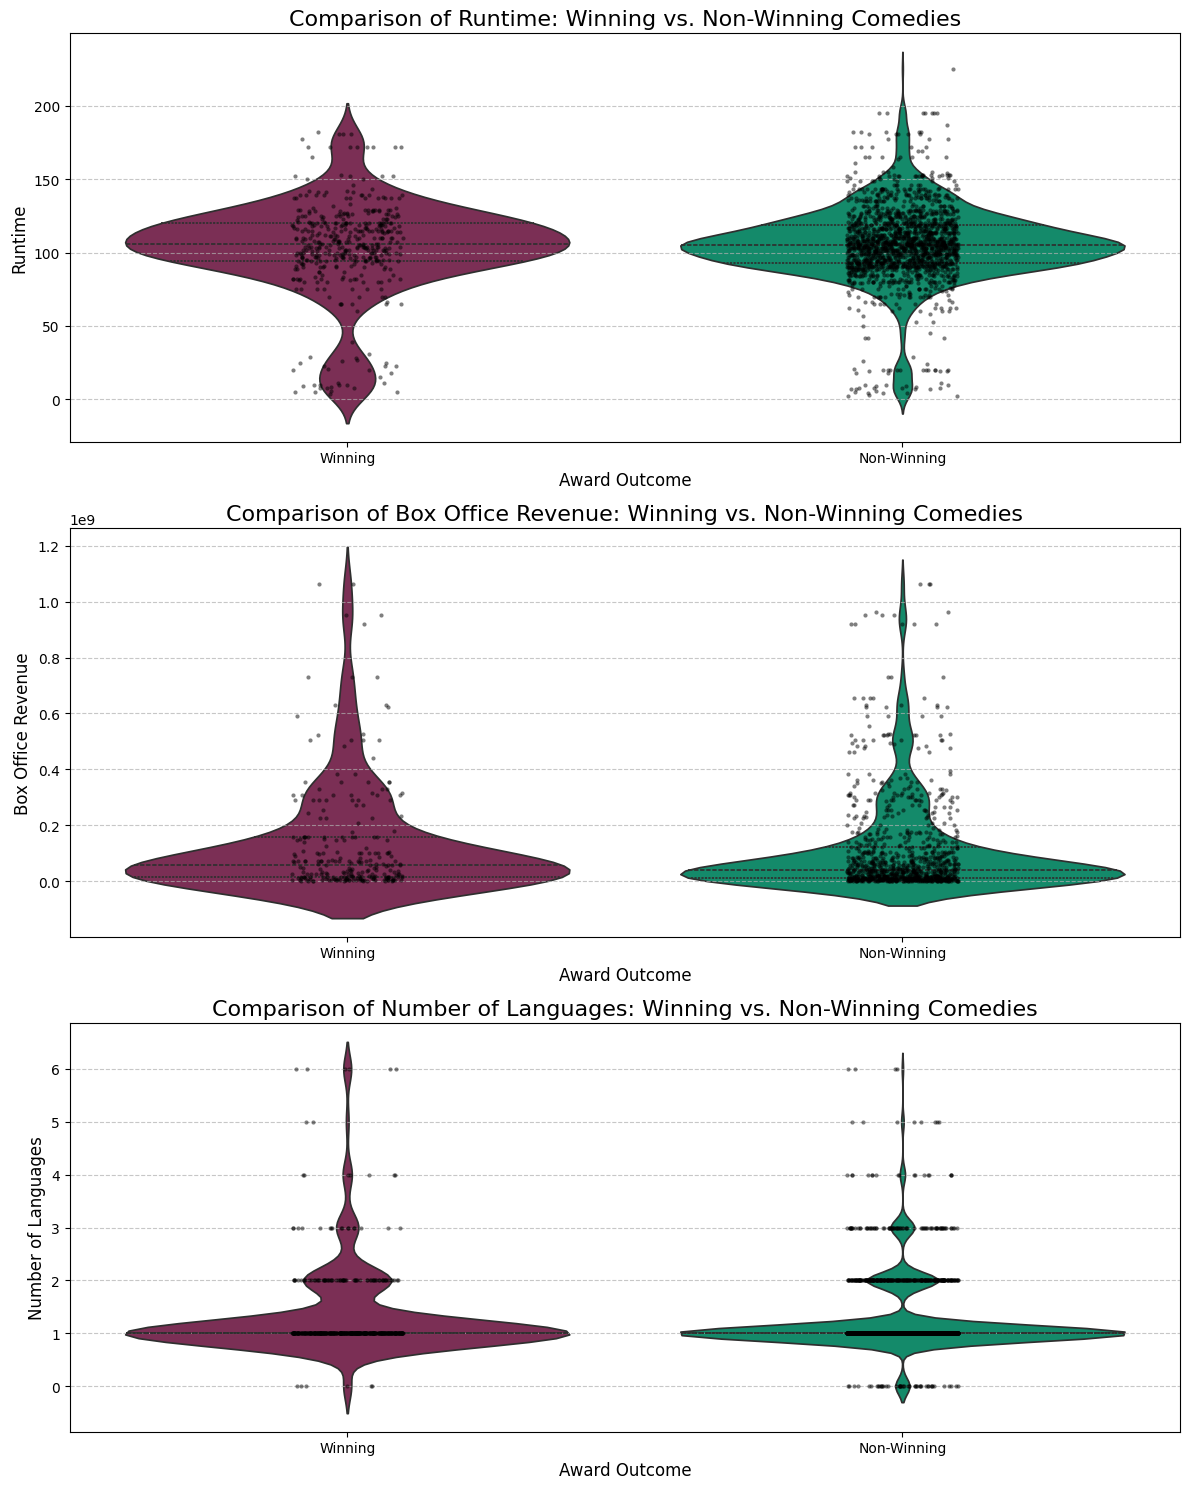

In [65]:
awards_comedy_movies = movies_awards[movies_awards['genres'].apply(lambda genres: 'Comedy' in genres)]    

# Step 1: Preprocess the data
comedy_features_df = preprocess_comedy_data(awards_comedy_movies)
    
# Step 2: Features to compare
features_to_compare = ['Runtime', 'Box Office Revenue', 'Number of Languages']
    
# Step 3: Plot the feature comparisons
plot_comedy_feature_comparison(comedy_features_df, features_to_compare, COLOR_PALETTE)


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def filter_comedy_movies(cmu_cleaned_movies):
    """
    Filters the comedy movies from the dataset and removes 'Comedy' genre from the genres column.
    
    Args:
        cmu_cleaned_movies (DataFrame): The dataset containing movie data including genres.
    
    Returns:
        DataFrame: Filtered and cleaned comedy movies dataset.
    """
    cmu_comedy_movies = cmu_cleaned_movies[cmu_cleaned_movies['genres'].apply(lambda genres: 'Comedy' in genres)]
    cmu_comedy_movies['genres'] = cmu_comedy_movies['genres'].apply(lambda g: [genre for genre in g if genre != 'Comedy'])
    return cmu_comedy_movies

def process_genre_by_country(cmu_comedy_movies):
    """
    Processes the comedy movies data to calculate the count of each genre by country.
    
    Args:
        cmu_comedy_movies (DataFrame): The filtered dataset of comedy movies.
    
    Returns:
        DataFrame: The processed dataset containing genre counts by country.
        list: List of top 8 countries by count of comedy genres.
    """
    genre_by_country = cmu_comedy_movies.explode('genres').explode('countries').groupby(['countries', 'genres']).size().reset_index(name='Count')
    
    # Get the top 10 genres
    top_genres = genre_by_country.groupby('genres')['Count'].sum().nlargest(10).index
    genre_by_country_filtered = genre_by_country[genre_by_country['genres'].isin(top_genres)]
    
    # Get the top 8 countries
    top_countries = genre_by_country_filtered.groupby('countries')['Count'].sum().nlargest(8).index
    genre_by_country_filtered = genre_by_country_filtered[genre_by_country_filtered['countries'].isin(top_countries)]
    
    return genre_by_country_filtered, top_countries

def plot_genres_by_country(genre_by_country_filtered, top_countries, color_palette):
    """
    Plots pie charts of the top comedy genres for each of the top countries.
    
    Args:
        genre_by_country_filtered (DataFrame): The filtered data containing genres and counts by country.
        top_countries (list): List of the top countries to plot.
        color_palette (list): List of colors to be used in the plot.
    """
    plt.figure(figsize=(18, 8))
    plt.subplots_adjust(wspace=1)

    # Plot a pie chart for each country
    for i, country in enumerate(top_countries):
        country_data = genre_by_country_filtered[genre_by_country_filtered['countries'] == country]
        
        plt.subplot(2, 4, i+1)
        plt.pie(country_data['Count'], labels=country_data['genres'], colors=color_palette[:len(country_data)], autopct='%1.1f%%')
        plt.title(country)
        plt.axis('equal')  # Ensure pie charts are circular

    plt.suptitle('Top Comedy Genres by Leading Countries', fontsize=16, fontweight='bold')
    plt.show()

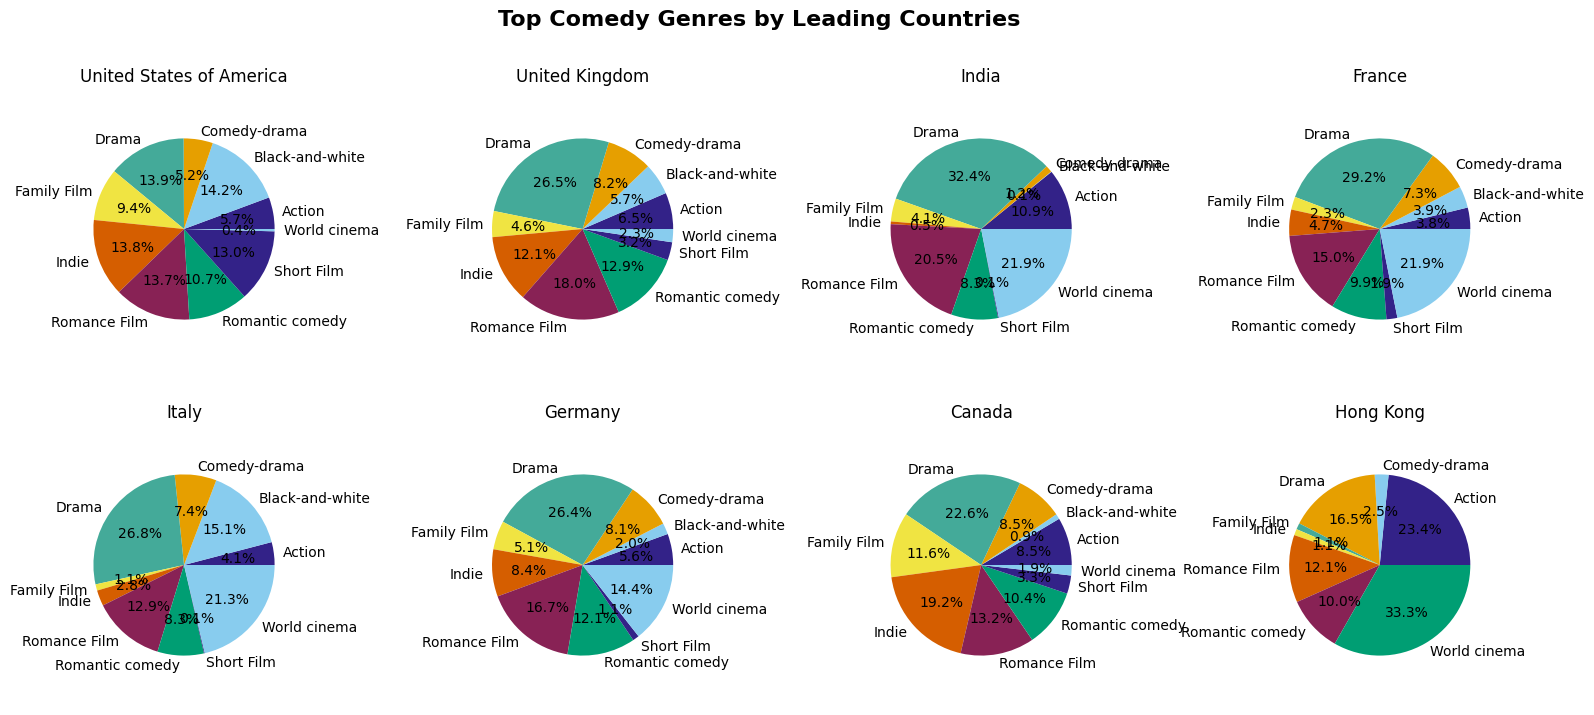

In [63]:
cmu_comedy_movies = filter_comedy_movies(cmu_cleaned_movies)
    
# Step 2: Process the data for genre by country
genre_by_country_filtered, top_countries = process_genre_by_country(cmu_comedy_movies)
    
# Step 3: Plot the data
plot_genres_by_country(genre_by_country_filtered, top_countries, COLOR_PALETTE)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process the movie data
def process_movies(df, start_year=1930, end_year=2010):
    """
    Processes movie data by filtering by release date, adding columns for 
    the number of languages and comedy flag.
    
    Args:
        df (DataFrame): The original movie data.
        start_year (int): The start year to filter the data (default is 1930).
        end_year (int): The end year to filter the data (default is 2010).
    
    Returns:
        DataFrame: The processed movie data.
    """
    df = df[(df['release_date'] >= start_year) & (df['release_date'] <= end_year)]
    df['num_languages'] = df['languages'].apply(len)  # Count of languages
    df['is_comedy'] = df['genres'].apply(lambda x: any('comedy' in genre.lower() for genre in x))  # Comedy flag
    return df

# Function to calculate the average number of languages per year
def calculate_languages_per_year(df):
    """
    Calculates the average number of languages per year for all movies and comedy movies.
    
    Args:
        df (DataFrame): The processed movie data.
    
    Returns:
        DataFrame: A DataFrame with average languages per year for both all and comedy movies.
    """
    all_languages_per_year = df.groupby('release_date')['num_languages'].mean()
    comedy_languages_per_year = df[df['is_comedy']].groupby('release_date')['num_languages'].mean()

    # Combine the results into a single DataFrame
    combined_df = pd.DataFrame({
        'Year': all_languages_per_year.index,
        'All_Movies_Languages': all_languages_per_year.values,
        'Comedy_Movies_Languages': comedy_languages_per_year.reindex(all_languages_per_year.index, fill_value=0).values
    })
    
    return combined_df

# Function to plot the regression of languages in movies vs comedy movies
def plot_languages_vs_comedy(combined_df, color_all='blue', color_comedy='orange'):
    """
    Plots the regression of languages in movies vs comedy movies over time.
    
    Args:
        combined_df (DataFrame): The DataFrame containing the average languages per year for all movies and comedy movies.
        color_all (str): The color for the regression line of all movies.
        color_comedy (str): The color for the regression line of comedy movies.
    """
    plt.figure(figsize=(12, 6))

    # Plot the regression lines for both all movies and comedy movies
    sns.regplot(data=combined_df, x='Year', y='All_Movies_Languages', 
                label='All Movies', scatter_kws={'s': 20}, line_kws={'color': color_all})
    sns.regplot(data=combined_df, x='Year', y='Comedy_Movies_Languages', 
                label='Comedy Movies', scatter_kws={'s': 20}, line_kws={'color': color_comedy})

    # Title and labels
    plt.title('Regression of Languages in Movies vs Comedy Movies (1930-2010)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Number of Languages', fontsize=14)
    plt.legend()

    # Adding grid for better readability
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

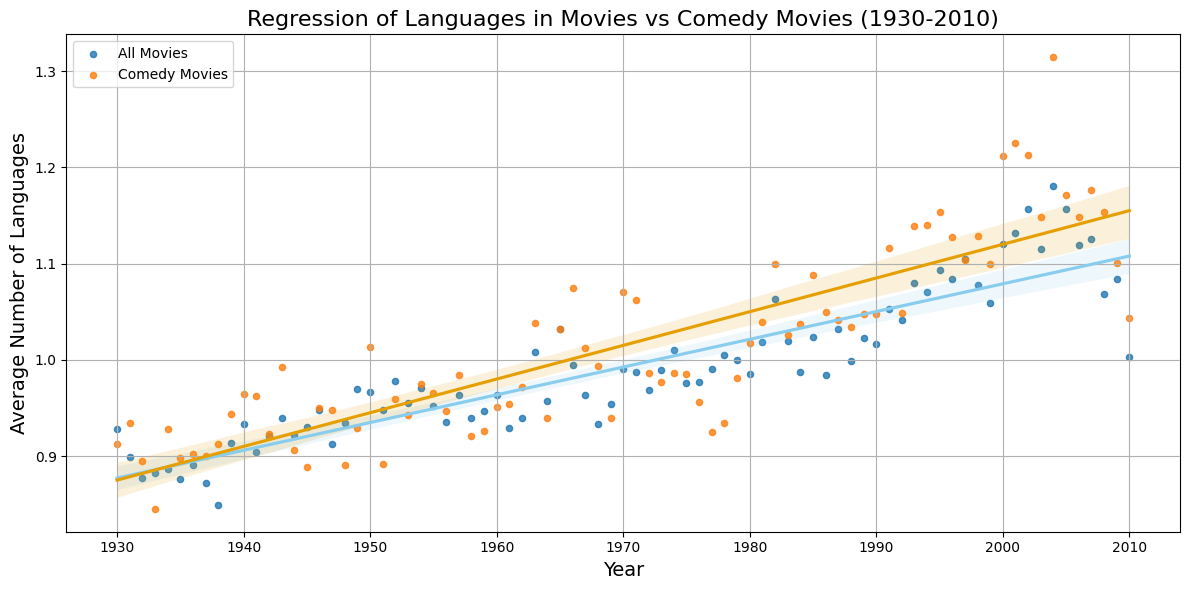

In [46]:
processed_movies = process_movies(cmu_cleaned_movies)
    
# Step 2: Calculate average languages per year
combined_df = calculate_languages_per_year(processed_movies)
    
# Step 3: Plot the results
plot_languages_vs_comedy(combined_df, COLOR_PALETTE[1], COLOR_PALETTE[2])

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# Function to perform linear regression and return results
def perform_linear_regression(X, y):
    """
    Performs linear regression and returns the model, slope, intercept, R-squared, p-value, and standard error.
    
    Args:
        X (array-like): Independent variable (e.g., Year).
        y (array-like): Dependent variable (e.g., number of languages).
    
    Returns:
        dict: Contains the model, regression results (slope, intercept, R-squared, p-value, std error).
    """
    model = LinearRegression().fit(X, y)
    predictions = model.predict(X)
    r2 = model.score(X, y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(X.flatten(), y)
    
    return {
        'model': model,
        'predictions': predictions,
        'r2': r2,
        'slope': slope,
        'intercept': intercept,
        'p_value': p_value,
        'std_err': std_err
    }

# Function to plot the regression results for All Movies and Comedy Movies
def plot_regression_results(combined_df, model_all, model_comedy, slope_all, slope_comedy):
    """
    Plots the scatterplot and regression lines for All Movies and Comedy Movies.
    
    Args:
        combined_df (DataFrame): The DataFrame containing the movie data.
        model_all (LinearRegression): The regression model for all movies.
        model_comedy (LinearRegression): The regression model for comedy movies.
        slope_all (float): The slope of the regression line for all movies.
        slope_comedy (float): The slope of the regression line for comedy movies.
    """
    plt.figure(figsize=(12, 6))

    # Scatter and regression for All Movies
    sns.scatterplot(x=combined_df['Year'], y=combined_df['All_Movies_Languages'], label='All Movies', color=COLOR_PALETTE[1])
    plt.plot(combined_df['Year'], model_all.predict(combined_df['Year'].values.reshape(-1, 1)), label=f'All Movies Trend (Slope={slope_all:.5f})', color=COLOR_PALETTE[1])

    # Scatter and regression for Comedy Movies
    sns.scatterplot(x=combined_df['Year'], y=combined_df['Comedy_Movies_Languages'], label='Comedy Movies', color=COLOR_PALETTE[2])
    plt.plot(combined_df['Year'], model_comedy.predict(combined_df['Year'].values.reshape(-1, 1)), label=f'Comedy Movies Trend (Slope={slope_comedy:.5f})', color=COLOR_PALETTE[2])

    # Title and labels
    plt.title('Statistical Analysis: Languages in Movies vs Comedy Movies', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Number of Languages', fontsize=14)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Function to run regression analysis and print the results
def print_regression_results(slope_all, intercept_all, r2_all, p_value_all, 
                             slope_comedy, intercept_comedy, r2_comedy, p_value_comedy):
    """
    Prints the results of the regression analysis.
    
    Args:
        slope_all, intercept_all, r2_all, p_value_all: Regression results for All Movies.
        slope_comedy, intercept_comedy, r2_comedy, p_value_comedy: Regression results for Comedy Movies.
    """
    print("All Movies Regression Results:")
    print(f"  Slope: {slope_all:.5f}, Intercept: {intercept_all:.2f}")
    print(f"  R-squared: {r2_all:.4f}, p-value: {p_value_all:.5f}\n")

    print("Comedy Movies Regression Results:")
    print(f"  Slope: {slope_comedy:.5f}, Intercept: {intercept_comedy:.2f}")
    print(f"  R-squared: {r2_comedy:.4f}, p-value: {p_value_comedy:.5f}")

All Movies Regression Results:
  Slope: 0.00288, Intercept: -4.69
  R-squared: 0.8186, p-value: 0.00000

Comedy Movies Regression Results:
  Slope: 0.00350, Intercept: -5.88
  R-squared: 0.7268, p-value: 0.00000


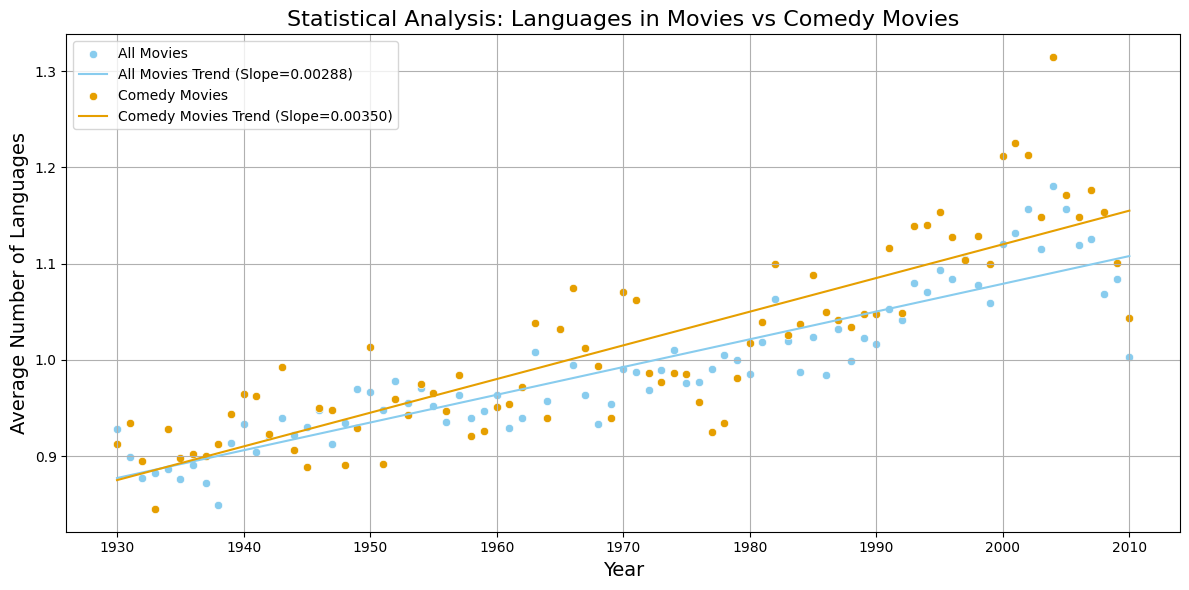

In [48]:
combined_df = combined_df.dropna()

# Define the independent variable (Year)
X = combined_df['Year'].values.reshape(-1, 1)

# Perform linear regression for All Movies and Comedy Movies
regression_results_all = perform_linear_regression(X, combined_df['All_Movies_Languages'].values)
regression_results_comedy = perform_linear_regression(X, combined_df['Comedy_Movies_Languages'].values)

# Print the regression results
print_regression_results(
    regression_results_all['slope'], regression_results_all['intercept'], regression_results_all['r2'], 
    regression_results_all['p_value'],
    regression_results_comedy['slope'], regression_results_comedy['intercept'], regression_results_comedy['r2'],
    regression_results_comedy['p_value']
)

# Plot the regression results
plot_regression_results(combined_df, regression_results_all['model'], regression_results_comedy['model'],
                        regression_results_all['slope'], regression_results_comedy['slope'])


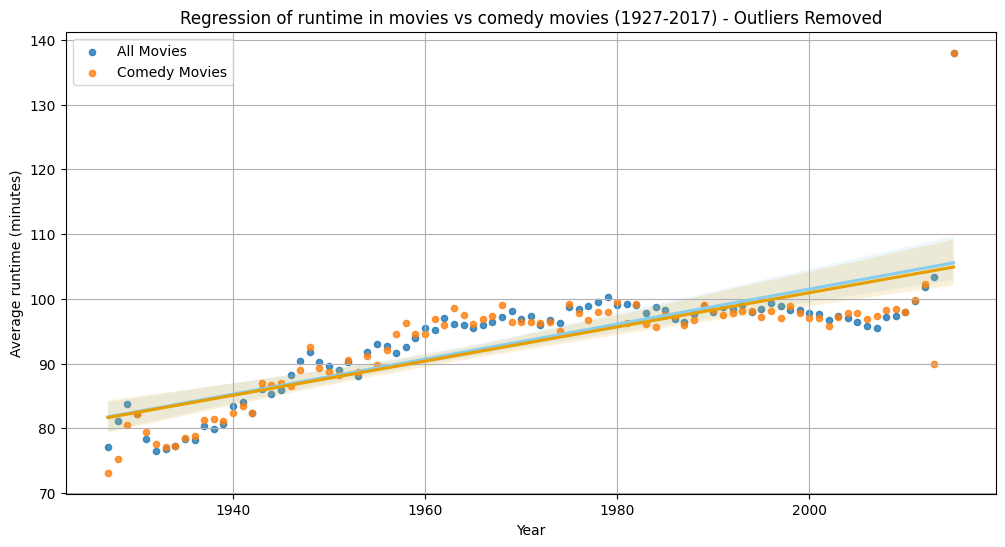

In [49]:
all_movies2 = cmu_cleaned_movies.copy().drop(columns=['wikipedia_id', 'freebase_id'])

def process_movies_runtime(df):
    df = df[(df['release_date'] >= 1927) & (df['release_date'] <= 2017)]
    df = df.dropna(subset=['runtime'])
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    df['is_comedy'] = df['genres'].apply(lambda x: any('comedy' in genre.lower() for genre in x))
    return df

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

processed_movies2 = process_movies_runtime(all_movies2)
filtered_movies = remove_outliers(processed_movies2, 'runtime')

all_runtime_per_year = filtered_movies.groupby('release_date')['runtime'].mean()
comedy_runtime_per_year = filtered_movies[filtered_movies['is_comedy']].groupby('release_date')['runtime'].mean()

combined_df2 = pd.DataFrame({
    'Year': all_runtime_per_year.index,
    'All_Movies_Runtime': all_runtime_per_year.values,
    'Comedy_Movies_Runtime': comedy_runtime_per_year.reindex(all_runtime_per_year.index, fill_value=0).values
})

plt.figure(figsize=(12, 6))

sns.regplot(data=combined_df2, x='Year', y='All_Movies_Runtime', 
            label='All Movies', scatter_kws={'s': 20}, line_kws={'color': COLOR_PALETTE[1]})

sns.regplot(data=combined_df2, x='Year', y='Comedy_Movies_Runtime', 
            label='Comedy Movies', scatter_kws={'s': 20}, line_kws={'color': COLOR_PALETTE[2]})

plt.title('Regression of runtime in movies vs comedy movies (1927-2017) - Outliers Removed')
plt.xlabel('Year')
plt.ylabel('Average runtime (minutes)')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
def process_movies_runtime(df, start_year=1927, end_year=2017):
    """
    Processes movies by filtering based on the release date and genres (Comedy).
    
    Args:
        df (DataFrame): The DataFrame containing movie data.
        start_year (int): The start year for filtering.
        end_year (int): The end year for filtering.
    
    Returns:
        DataFrame: Processed movie data with runtime and genre information.
    """
    df = df[(df['release_date'] >= start_year) & (df['release_date'] <= end_year)]
    df = df.dropna(subset=['runtime'])
    df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce')
    df['is_comedy'] = df['genres'].apply(lambda x: any('comedy' in genre.lower() for genre in x))
    return df

# Function to remove outliers from a given column based on IQR (Interquartile Range)
def remove_outliers(df, column):
    """
    Removes outliers from a specified column using the IQR method.
    
    Args:
        df (DataFrame): The DataFrame containing the movie data.
        column (str): The column name to remove outliers from.
    
    Returns:
        DataFrame: The filtered DataFrame without outliers.
    """
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Function to calculate the average runtime per year for all and comedy movies
def calculate_runtime_per_year(df):
    """
    Calculates the average runtime per year for all movies and comedy movies.
    
    Args:
        df (DataFrame): The filtered DataFrame containing movie data.
    
    Returns:
        DataFrame: A DataFrame with average runtime for all and comedy movies by year.
    """
    all_runtime_per_year = df.groupby('release_date')['runtime'].mean()
    comedy_runtime_per_year = df[df['is_comedy']].groupby('release_date')['runtime'].mean()

    combined_df = pd.DataFrame({
        'Year': all_runtime_per_year.index,
        'All_Movies_Runtime': all_runtime_per_year.values,
        'Comedy_Movies_Runtime': comedy_runtime_per_year.reindex(all_runtime_per_year.index, fill_value=0).values
    })

    return combined_df

# Function to plot the regression of runtime for all movies and comedy movies
def plot_runtime_regression(combined_df):
    """
    Plots the regression of runtime in all movies vs comedy movies.
    
    Args:
        combined_df (DataFrame): The DataFrame containing the average runtime data.
    """
    plt.figure(figsize=(12, 6))

    sns.regplot(data=combined_df, x='Year', y='All_Movies_Runtime', 
                label='All Movies', scatter_kws={'s': 20}, line_kws={'color': COLOR_PALETTE[1]})

    sns.regplot(data=combined_df, x='Year', y='Comedy_Movies_Runtime', 
                label='Comedy Movies', scatter_kws={'s': 20}, line_kws={'color': COLOR_PALETTE[2]})

    plt.title('Regression of Runtime in Movies vs Comedy Movies (1927-2017) - Outliers Removed')
    plt.xlabel('Year')
    plt.ylabel('Average Runtime (minutes)')
    plt.legend()
    plt.grid(True)
    plt.show()

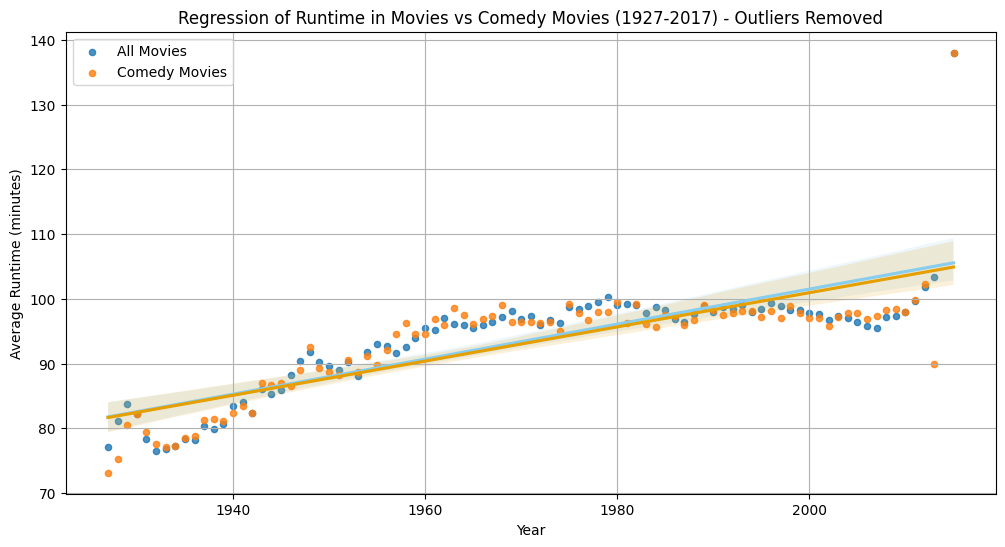

In [51]:
all_movies2 = cmu_cleaned_movies.copy().drop(columns=['wikipedia_id', 'freebase_id'])

processed_movies = process_movies_runtime(all_movies2)

# Step 2: Remove outliers in the 'runtime' column
filtered_movies = remove_outliers(processed_movies, 'runtime')

# Step 3: Calculate average runtime per year for all and comedy movies
combined_df = calculate_runtime_per_year(filtered_movies)

# Step 4: Plot the regression results
plot_runtime_regression(combined_df)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to filter comedy movies that have won awards
def filter_comedy_movies_awards(df):
    return df[
        (df['genres'].apply(lambda x: 'Comedy' in x if isinstance(x, list) else False)) &
        (df['winner'] == True)
    ]

# Function to calculate the per-year normalized box office revenue (PYNBOR)
def calculate_pynbor(df):
    mean_revenue_by_year = df.groupby('release_date')['box_office_revenue'].mean().rename('mean_revenue_for_year')
    df = df.merge(mean_revenue_by_year, on='release_date')
    df['PYNBOR'] = df['box_office_revenue'] / df['mean_revenue_for_year']
    return df

# Function to aggregate success data for comedy movies
def aggregate_comedy_success(df):
    comedy_success_data = df.groupby('title').agg({
        'box_office_revenue': 'mean',
        'release_date': 'mean',
        'winner': 'count',
        'PYNBOR': 'mean'
    }).reset_index().rename(columns={'winner': 'total_wins'})
    comedy_success_data = comedy_success_data.dropna(subset=['PYNBOR'])
    return comedy_success_data

# Function to plot the comedy success data
def plot_comedy_success(comedy_success_data):
    plt.figure(figsize=(12, 8))
    bubble = plt.scatter(
        x=comedy_success_data['PYNBOR'],
        y=comedy_success_data['total_wins'],
        s=comedy_success_data['total_wins'] * 100,  # Bubble size proportional to wins
        alpha=0.6,
        color=COLOR_PALETTE[4],
        edgecolors='k'
    )
    
    plt.title("Comedy Movie Success: Total Wins vs Per-Year-Normalized Box Office Revenue", fontsize=16)
    plt.xlabel("Per-Year-Normalized Box Office Revenue (PYNBOR)", fontsize=12)
    plt.ylabel("Number of Awards", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Annotating the top 5 comedy movies
    top_comedy_movies = comedy_success_data.nlargest(5, 'total_wins')
    for i, row in top_comedy_movies.iterrows():
        plt.text(row['PYNBOR'], row['total_wins'], row['title'], fontsize=10)

    plt.tight_layout()
    plt.show()

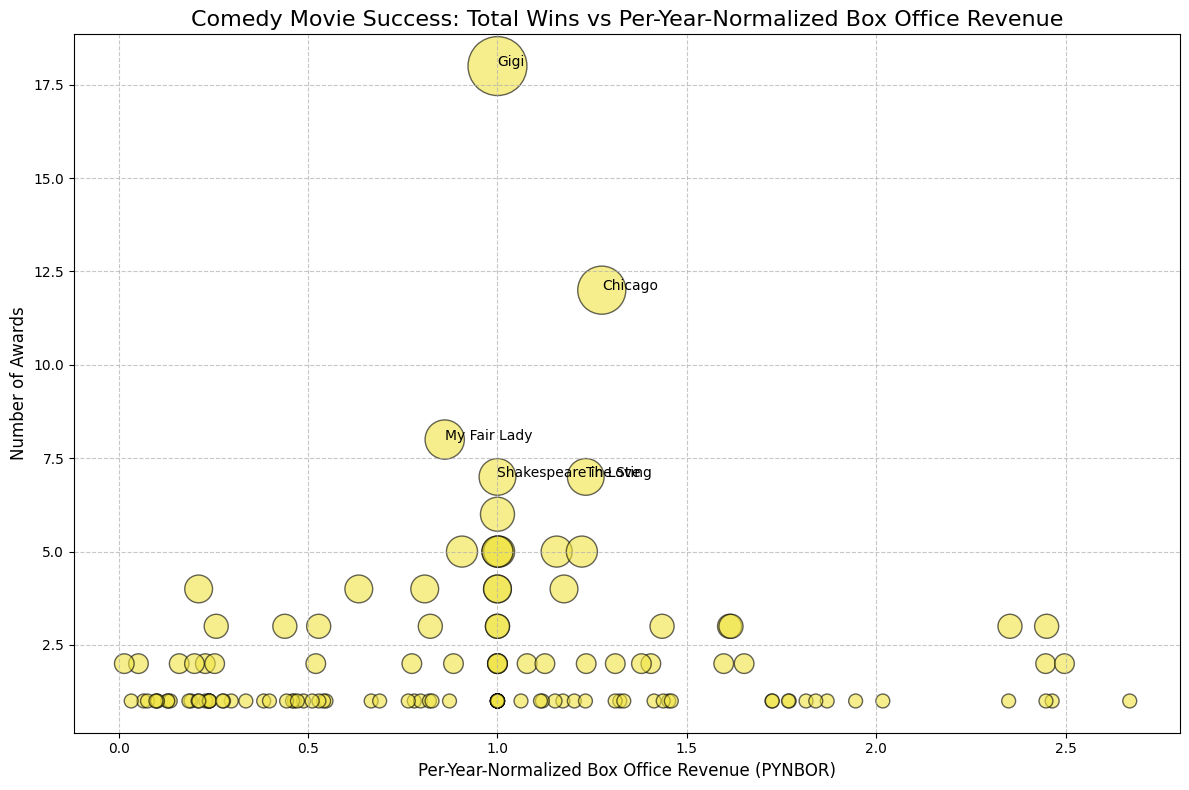

In [53]:
comedy_movies = filter_comedy_movies_awards(movies_awards)
    
# Step 2: Calculate the per-year normalized box office revenue (PYNBOR)
comedy_movies = calculate_pynbor(comedy_movies)
    
# Step 3: Aggregate success data for comedy movies
comedy_success_data = aggregate_comedy_success(comedy_movies)
    
# Step 4: Plot the results
plot_comedy_success(comedy_success_data)

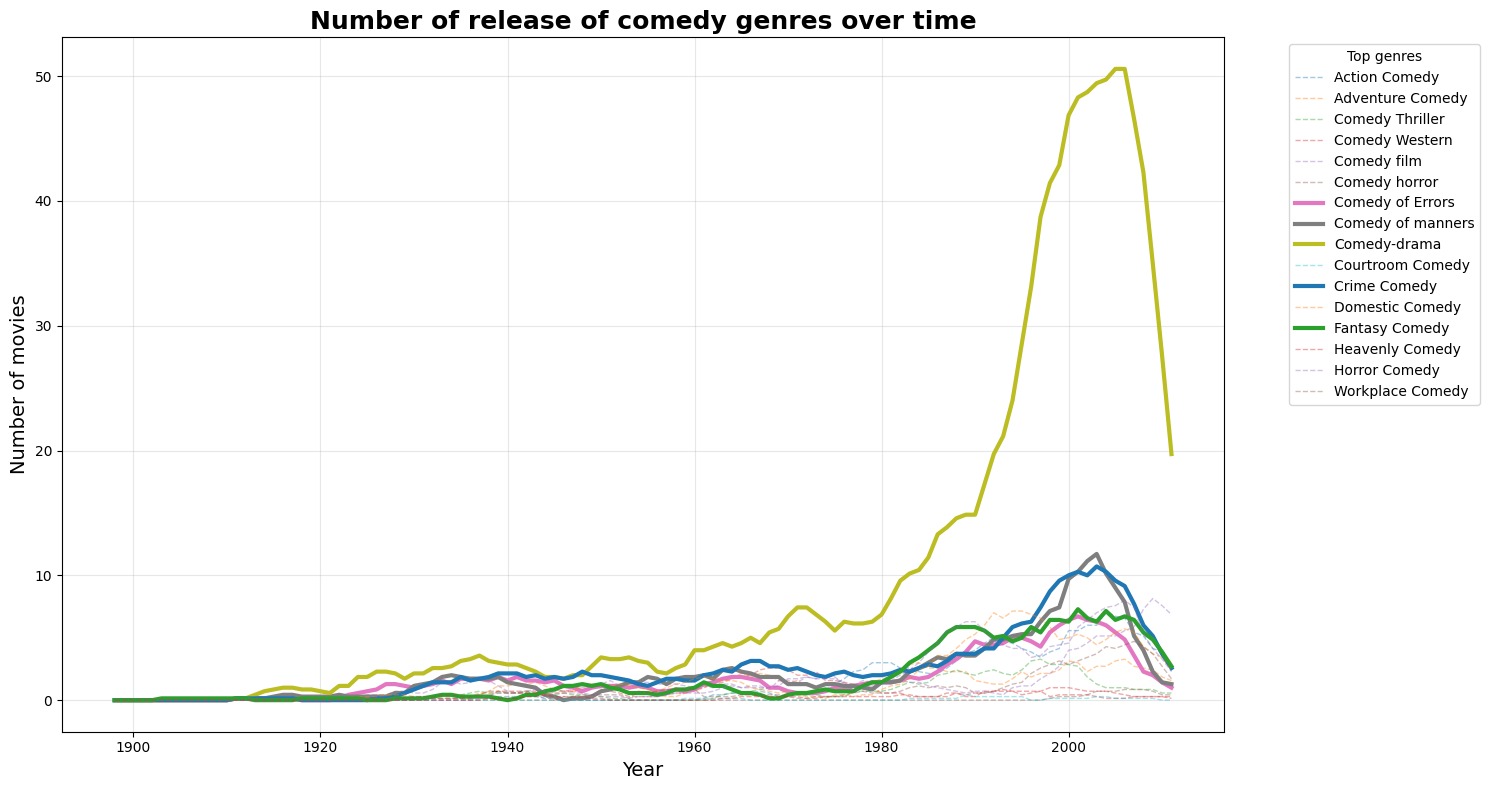

In [54]:
movies_exploded_genres = cmu_comedies.explode('genres')
comedy_genres = movies_exploded_genres[movies_exploded_genres['genres'].str.contains('Comedy', na=False)]

comedy_genres_count = comedy_genres.groupby(['release_date', 'genres']).size().reset_index(name='count')
comedy_genres_pivot = comedy_genres_count.pivot(index='release_date', columns='genres', values='count').fillna(0).drop(columns='Comedy')
smoothed_comedy_genres = comedy_genres_pivot.rolling(window=7, center=True).mean()

fig, ax = plt.subplots(figsize=(15, 8))

top_genres = comedy_genres_pivot.sum().sort_values(ascending=False).head(5).index
for genre in smoothed_comedy_genres.columns:
    if genre in top_genres:
        smoothed_comedy_genres[genre].plot(ax=ax, linewidth=3, label=genre) 
    else:
        smoothed_comedy_genres[genre].plot(ax=ax, linewidth=1, alpha=0.4, label=genre, linestyle='--')  

plt.title("Number of release of comedy genres over time", fontsize=18, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of movies", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title="Top genres", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

plt.show()


In [55]:
# Function to explode genres and filter for Comedy genres
def explode_and_filter_comedy_genres(df):
    movies_exploded_genres = df.explode('genres')
    comedy_genres = movies_exploded_genres[movies_exploded_genres['genres'].str.contains('Comedy', na=False)]
    return comedy_genres

# Function to count the number of releases for each genre per year
def count_comedy_genres_by_year(comedy_genres):
    comedy_genres_count = comedy_genres.groupby(['release_date', 'genres']).size().reset_index(name='count')
    return comedy_genres_count

# Function to pivot the data: rows = years, columns = genres, values = counts
def pivot_genre_data(comedy_genres_count):
    comedy_genres_pivot = comedy_genres_count.pivot(index='release_date', columns='genres', values='count').fillna(0).drop(columns='Comedy')
    return comedy_genres_pivot

# Function to apply rolling average to smooth the data
def smooth_data(genre_data, window_size=7):
    smoothed_data = genre_data.rolling(window=window_size, center=True).mean()
    return smoothed_data

# Function to plot the comedy genres data
def plot_comedy_genres(smoothed_comedy_genres):
    fig, ax = plt.subplots(figsize=(15, 8))

    # Identify top genres based on the total number of releases
    top_genres = smoothed_comedy_genres.sum().sort_values(ascending=False).head(5).index

    # Plot the top genres with a thicker line
    for genre in smoothed_comedy_genres.columns:
        if genre in top_genres:
            smoothed_comedy_genres[genre].plot(ax=ax, linewidth=3, label=genre)  # Top genres with thicker lines
        else:
            smoothed_comedy_genres[genre].plot(ax=ax, linewidth=1, alpha=0.4, label=genre, linestyle='--')  # Other genres with dashed lines

    # Title and labels
    plt.title("Number of Releases for Comedy Genres Over Time", fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Number of Movies Released", fontsize=14)

    # Grid and legend
    plt.grid(alpha=0.3)
    plt.legend(title="Top Genres", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Adjust layout to fit everything in
    plt.tight_layout()

    # Show the plot
    plt.show()

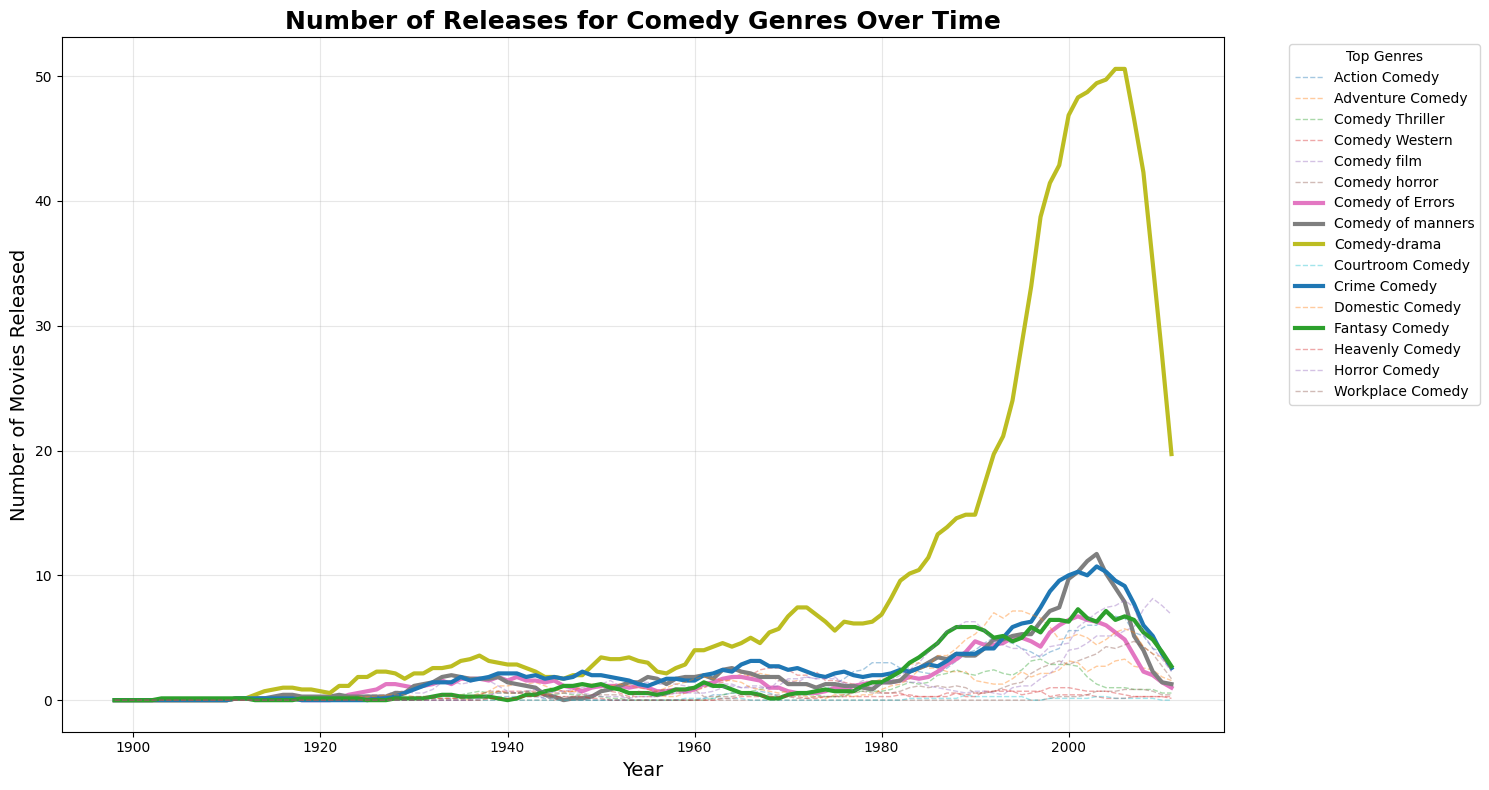

In [56]:
comedy_genres = explode_and_filter_comedy_genres(cmu_comedies)
comedy_genres_count = count_comedy_genres_by_year(comedy_genres)
comedy_genres_pivot = pivot_genre_data(comedy_genres_count)
smoothed_comedy_genres = smooth_data(comedy_genres_pivot)
plot_comedy_genres(smoothed_comedy_genres)

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to group comedy genres by release date and genre
def count_comedy_genres_by_release_and_genre(comedy_genres):
    comedy_genres_count = comedy_genres.groupby(['release_date', 'genres']).size().reset_index(name='count')
    return comedy_genres_count

# Function to assign each movie to a decade
def assign_decade_to_genres(comedy_genres_count):
    comedy_genres_count['decade'] = (comedy_genres_count['release_date'] // 10) * 10
    return comedy_genres_count

# Function to calculate the total count of genres by decade
def count_genres_by_decade(comedy_genres_count):
    decade_genre_counts = comedy_genres_count.groupby(['decade', 'genres'])['count'].sum().reset_index()
    return decade_genre_counts

# Function to pivot the genre counts into a pivot table
def pivot_genre_data_by_decade(decade_genre_counts):
    decade_genre_pivot = decade_genre_counts.pivot(index='decade', columns='genres', values='count').fillna(0)
    # Drop the "Comedy" column if it exists
    if 'Comedy' in decade_genre_pivot.columns:
        decade_genre_pivot = decade_genre_pivot.drop(columns='Comedy')
    return decade_genre_pivot

# Function to calculate proportions of each genre within a decade
def calculate_genre_proportions(decade_genre_pivot):
    decade_proportion = decade_genre_pivot.div(decade_genre_pivot.sum(axis=1), axis=0)
    return decade_proportion

# Function to plot the stacked bar chart for genre proportions by decade
def plot_genre_proportions(decade_proportion, color_palette):
    plt.figure(figsize=(15, 8))

    decade_proportion.plot(
        kind='bar',
        stacked=True,
        color=color_palette[:len(decade_proportion.columns)], 
        alpha=0.9,
        width=0.8
    )

    plt.title("Proportion of Comedy Sub-genres by Decade (Excluding Simply Comedy)", fontsize=16)
    plt.xlabel("Decade", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Comedy Sub-genres", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


<Figure size 1500x800 with 0 Axes>

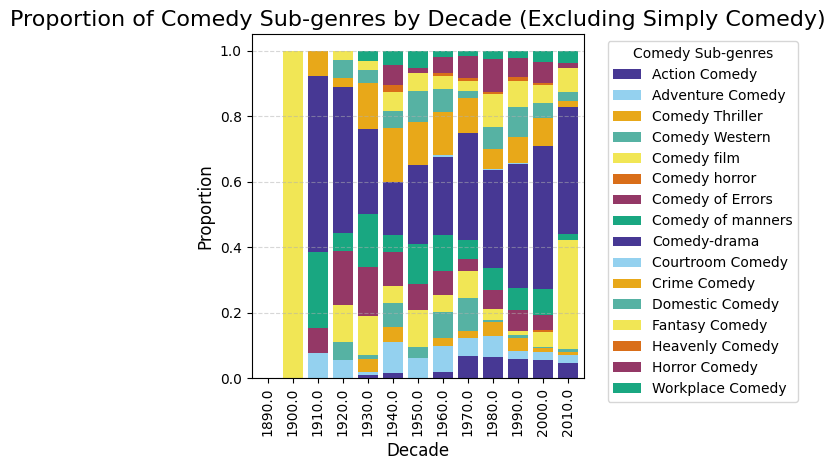

In [58]:
comedy_genres_count = count_comedy_genres_by_release_and_genre(comedy_genres)
comedy_genres_count = assign_decade_to_genres(comedy_genres_count)
decade_genre_counts = count_genres_by_decade(comedy_genres_count)
decade_genre_pivot = pivot_genre_data_by_decade(decade_genre_counts)
decade_proportion = calculate_genre_proportions(decade_genre_pivot)
plot_genre_proportions(decade_proportion, COLOR_PALETTE)

In [59]:
example_movies = comedy_genres[['genres', 'title']].dropna()
example_per_genre = example_movies.groupby('genres')['title'].first().reset_index()
print("Example Movies for Each Comedy Sub-genre:\n")
for _, row in example_per_genre.iterrows():
    print(f"Sub-genre: {row['genres']} -> Example Movie: {row['title']}")

Example Movies for Each Comedy Sub-genre:

Sub-genre: Action Comedy -> Example Movie: The Human Tornado
Sub-genre: Adventure Comedy -> Example Movie: The Gods Must Be Crazy
Sub-genre: Comedy -> Example Movie: The Gangsters
Sub-genre: Comedy Thriller -> Example Movie: Davitelj protiv davitelja
Sub-genre: Comedy Western -> Example Movie: The Hallelujah Trail
Sub-genre: Comedy film -> Example Movie: The Thirteen Chairs
Sub-genre: Comedy horror -> Example Movie: Ispiritista: Itay, may moomoo!
Sub-genre: Comedy of Errors -> Example Movie: Black Cat, White Cat
Sub-genre: Comedy of manners -> Example Movie: Stage Beauty
Sub-genre: Comedy-drama -> Example Movie: Little city
Sub-genre: Courtroom Comedy -> Example Movie: Find Me Guilty
Sub-genre: Crime Comedy -> Example Movie: Things to Do in Denver When You're Dead
Sub-genre: Domestic Comedy -> Example Movie: What Have I Done To Deserve This?
Sub-genre: Fantasy Comedy -> Example Movie: 14 Going on 30
Sub-genre: Heavenly Comedy -> Example Movie: